In [111]:
# March Madness

# libraries
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import random
import re
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skewnorm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import normaltest
from scipy.stats import wilcoxon

In [112]:
# Name Cleaner

def name_Cleaner(df):
    df['Name'] = df['Name'].str.replace('Alabama-Birmingham','UAB')
    df['Name'] = df['Name'].str.replace('Cal State Fullerton','CSU Fullerton')
    df['Name'] = df['Name'].str.replace('Louisiana State','LSU')
    df['Name'] = df['Name'].str.replace('Loyola \(IL\)','Loyola Chicago')
    df['Name'] = df['Name'].str.replace('Miami \(FL\)','Miami')
    df['Name'] = df['Name'].str.replace("Saint Mary's \(CA\)","Saint Mary's")
    df['Name'] = df['Name'].str.replace('Southern California','USC')
    df['Name'] = df['Name'].str.replace('Texas Christian','TCU')
    df['Name'] = df['Name'].str.replace('Cal St. Fullerton','CSU Fullerton')
    df['Name'] = df['Name'].str.replace('Miami FL','Miami')
    df['Name'] = df['Name'].str.replace('Connecticut','UConn')
    df['Name'] = df['Name'].str.replace('St.?$','State')
    df['Name'] = df['Name'].str.replace('NC State','North Carolina State')
    df['Name'] = df['Name'].str.replace('St ','St. ')
    df['Name'] = df['Name'].str.replace(';','')
    df['Name'] = df['Name'].str.replace('Saint','St.')
    df['Name'] = df['Name'].str.replace('Ole Miss','Mississippi')
    df['Name'] = df['Name'].str.replace('^Cal ','UC ')
    df['Name'] = df['Name'].str.replace('Central Florida','UCF')
    df['Name'] = df['Name'].str.replace('UC St.','CSU')
    df['Name'] = df['Name'].str.replace('Pennsylvania','Penn')
    df['Name'] = df['Name'].str.replace('Texas San Antonio','UTSA')
    df['Name'] = df['Name'].str.replace('Texas Arlington','UT Arlington')
    df['Name'] = df['Name'].str.replace('Texas A&M Corpus Christi','Texas A&M Corpus Chris')
    df['Name'] = df['Name'].str.replace('UC Santa Barbara','Santa Barbara')
    df['Name'] = df['Name'].str.replace('St. Francis PA','St. Francis')
    df['Name'] = df['Name'].str.replace('S Dakota St','South Dakota State')
    df['Name'] = df['Name'].str.replace("J'Ville St",'Jacksonville State')
    df['Name'] = df['Name'].str.replace('Stateate','State')
    df['Name'] = df['Name'].str.replace('N.C. State','North Carolina State')
    df['Name'] = df['Name'].str.replace('Gardner-Webb','Gardner Webb')
    df['Name'] = df['Name'].str.replace('UCSB','UC Santa Barbara')
    df['Name'] = df['Name'].str.replace('E Washington','Eastern Washington')
    df['Name'] = df['Name'].str.replace('Virginia Commonwealth','VCU')
    df['Name'] = df['Name'].str.replace('Brigham Young','BYU')
    df['Name'] = df['Name'].str.replace('North Carolina-Greensboro','UNC Greensboro')
    df['Name'] = df['Name'].str.replace('UC-Santa Barbara','UC Santa Barbara')
    df['Name'] = df['Name'].str.replace('^Santa Barbara','UC Santa Barbara')
    df['Name'] = df['Name'].str.replace('College of ','')
    df['Name'] = df['Name'].str.replace('Louisiana-Lafayette','Louisiana')
    df['Name'] = df['Name'].str.replace('N Kentucky','Northern Kentucky')
    df['Name'] = df['Name'].str.replace('North Carolina-Asheville','UNC Asheville')
    df['Name'] = df['Name'].str.replace('Texas A&M-Corpus Christi','Texas A&M Corpus Chris')
    return df

In [113]:
# Data Processing

# Read non-yearly data
seed = pd.read_csv('data/seed.csv')
kenpom_rat = pd.read_csv('data/kenpom.csv')
teams = pd.read_csv('data/teams.csv')

# Clean Name
## full kenpom ratings
kenpom_rat = name_Cleaner(kenpom_rat)

# Seed
# convert dtype
seed['Seed 1'] = seed['Seed 1'].astype(str)
seed['Seed 2'] = seed['Seed 2'].astype(str)

# Full Matchups
## determine outcome
for outcome, opp in zip(['Outcome 1','Outcome 2','Outcome 3','Outcome 4','Outcome 5'],
                       ['Opp_2','Opp_3','Opp_4','Opp_5','Opp_6']):
    teams[outcome] = 1
    teams.loc[teams[opp].isna(),outcome] = 0
    
## outcome for final rd hardcoded (due to seed ties)
teams['Outcome 6'] = 0
teams.loc[(teams['Opp_6'].isna()==False)&(teams['Year']>=2017),'Outcome 6'] = [1,0,0,1,0,1,0,0,1,1]

## subset years
teams = teams.loc[teams['Year']>=2017]

## clean name
teams = teams.rename(columns = {'Team':'Name'})
teams = name_Cleaner(teams)
teams = teams.rename(columns = {'Name':'Team'})

## find all matchups in all rounds
data1 = {'Team 1':teams['Team'],'Team 2':teams['Opp_1'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 1']}
matchup1 = pd.DataFrame(data1)
data2 = {'Team 1':teams['Team'],'Team 2':teams['Opp_2'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 2']}
matchup2 = pd.DataFrame(data2)
data3 = {'Team 1':teams['Team'],'Team 2':teams['Opp_3'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 3']}
matchup3 = pd.DataFrame(data3)
data4 = {'Team 1':teams['Team'],'Team 2':teams['Opp_4'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 4']}
matchup4 = pd.DataFrame(data4)
data5 = {'Team 1':teams['Team'],'Team 2':teams['Opp_5'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 5']}
matchup5 = pd.DataFrame(data5)
data6 = {'Team 1':teams['Team'],'Team 2':teams['Opp_6'],'Year':teams['Year'],'Seed 1':teams['Seed'],'Outcome':teams['Outcome 6']}
matchup6 = pd.DataFrame(data6)
full_matchups = pd.concat([matchup1,matchup2,matchup3,matchup4,matchup5,matchup6])

## drop nas (teams in rounds w/ no matchup)
full_matchups.dropna(inplace=True)
full_matchups.reset_index(inplace=True)
full_matchups.drop(columns='index',inplace=True)

## clean names
full_matchups.columns = ['Team 1','Name','Year','Seed 1','Outcome']
full_matchups = name_Cleaner(full_matchups)
full_matchups.columns = ['Team 1','Team 2','Year','Seed 1','Outcome']

## find seed of 2nd team
full_matchups['Seed 2'] = 0
for year, team in zip(full_matchups['Year'],full_matchups['Team 2']):
    full_matchups.loc[(full_matchups['Year']==year)&(full_matchups['Team 2']==team),'Seed 2'] = teams.loc[(teams['Team']==team)&(teams['Year']==year),'Seed'].item()
    
## remove duplicates
full_matchups = full_matchups.loc[full_matchups['Seed 1']<=full_matchups['Seed 2']]
full_matchups.drop([606,622,621],inplace=True)

## reset index
full_matchups.reset_index(inplace=True)
full_matchups.drop(columns='index',inplace=True)


In [114]:
# Clean Yearly Data

def clean_Data(espn_file,fivethirtyeight_file,fivethirtyeight_date,fivethirtyeight_remove,kenpom_rat,year):
    # read data
    espn = pd.read_csv(espn_file)
    fivethirtyeight = pd.read_csv(fivethirtyeight_file)
    
    # 538
    ## most recent year and mens tournament
    fivethirtyeight = fivethirtyeight[(fivethirtyeight['gender']=='mens')&
                   (fivethirtyeight['forecast_date']==fivethirtyeight_date)].reset_index()
    ## drop cols
    fivethirtyeight.drop(columns=['rd1_win','gender','forecast_date','team_alive',
                                  'team_id','team_slot','playin_flag','team_rating',
                                  'results_to','index'],inplace=True)
    ## rename cols
    fivethirtyeight.columns = ['R64','R32','S16','E8','F4','NCG',
                               'Name','Region','Seed']
    # fix seed label
    fivethirtyeight['Seed'] = fivethirtyeight['Seed'].str.replace('16.+','16')
    fivethirtyeight['Seed'] = fivethirtyeight['Seed'].str.replace('11.+','11')
    fivethirtyeight['Seed'] = fivethirtyeight['Seed'].str.replace('12.+','12')

    # ESPN
    ## split name and percentage
    espn[['64Name','R64']] =  espn['R64'].str.split('-', 1, expand=True)
    espn['64Name'] = espn['64Name'].str.replace('\d+', '')
    espn[['32Name','R32']] = espn['R32'].str.split('-', 1, expand=True)
    espn['32Name'] = espn['32Name'].str.replace('\d+', '')
    espn[['16Name','S16']] = espn['S16'].str.split('-', 1, expand=True)
    espn['16Name'] = espn['16Name'].str.replace('\d+', '')
    espn[['8Name','E8']] = espn['E8'].str.split('-', 1, expand=True)
    espn['8Name'] = espn['8Name'].str.replace('\d+', '')
    espn[['4Name','F4']] = espn['F4'].str.split('-', 1, expand=True)
    espn['4Name'] = espn['4Name'].str.replace('\d+', '')
    espn[['NCGName','NCG']] = espn['NCG'].str.split('-', 1, expand=True)
    espn['NCGName'] = espn['NCGName'].str.replace('\d+', '')
    
    ## fix names being out of orders
    R64 = espn[['64Name','R64']]
    R32 = espn[['32Name','R32']]
    S16 = espn[['16Name','S16']]
    E8 = espn[['8Name','E8']]
    F4 = espn[['4Name','F4']]
    NCG = espn[['NCGName','NCG']]
    espn = pd.merge(R64,R32,left_on='64Name',right_on='32Name')
    espn = pd.merge(espn,S16,left_on='64Name',right_on='16Name')
    espn = pd.merge(espn,E8,left_on='64Name',right_on='8Name')
    espn = pd.merge(espn,F4,left_on='64Name',right_on='4Name')
    espn = pd.merge(espn,NCG,left_on='64Name',right_on='NCGName')
    espn.drop(columns=['32Name','16Name','8Name','4Name','NCGName'],inplace=True)
    espn.columns = ['Name','R64','R32','S16','E8','F4','NCG']
    
    ## subset string, only include probability
    if year == 2022:
        espn['R64'] = espn['R64'].str[:-1].replace('-','')
        espn['R32'] = espn['R32'].str[-5:-1].replace('-','')
        espn['S16'] = espn['S16'].str[-5:-1].replace('-','')
        espn['E8'] = espn['E8'].str[-5:-1].replace('-','')
        espn['F4'] = espn['F4'].str[-5:-1].replace('-','')
        espn['NCG'] = espn['NCG'].str[-5:-1]
    else:
        espn['R64'] = espn['R64'].str[:-1].replace('-','')
        espn['R32'] = espn['R32'].str[-6:-1].replace('-','')
        espn['S16'] = espn['S16'].str[-6:-1].replace('-','')
        espn['E8'] = espn['E8'].str[-6:-1].replace('-','')
        espn['F4'] = espn['F4'].str[-6:-1].replace('-','')
        espn['NCG'] = espn['NCG'].str[-6:-1]
        
    ## remove dash, convert to float, divide by 100
    espn['R64'] = espn['R64'].str.replace('-','').astype(float) / 100
    espn['R32'] = espn['R32'].str.replace('-','').astype(float) / 100
    espn['S16'] = espn['S16'].str.replace('-','').astype(float) / 100
    espn['E8'] = espn['E8'].str.replace('-','').astype(float) / 100
    espn['F4'] = espn['F4'].str.replace('-','').astype(float) / 100
    espn['NCG'] = espn['NCG'].str.replace('-','').astype(float) / 100
    
    # Naming Conventions
    ## espn
    espn = name_Cleaner(espn)
    ## 538
    fivethirtyeight = name_Cleaner(fivethirtyeight)
    
    # 538
    ## remove unused teams
    fivethirtyeight = fivethirtyeight[(fivethirtyeight['Name'] != fivethirtyeight_remove[0])&
                                      (fivethirtyeight['Name'] != fivethirtyeight_remove[1])&
                                      (fivethirtyeight['Name'] != fivethirtyeight_remove[2])&
                                      (fivethirtyeight['Name'] != fivethirtyeight_remove[3])]
    
    # Yearly KenPom
    kenpom = kenpom_rat.loc[kenpom_rat['Year']==year]

    ## remove unnecessary rows
    kenpom = kenpom[kenpom['Name'].isin(espn['Name'])]


    # Merging
    ## merge seed and region
    kenpom = kenpom.merge(fivethirtyeight,on='Name').drop(columns=['R64','R32',
                                                         'S16','E8',
                                                         'F4','NCG'])
    ## merge seed and reason
    espn = espn.merge(fivethirtyeight,on='Name').drop(columns=['R64_y','R32_y',
                                                         'S16_y','E8_y',
                                                         'F4_y','NCG_y'])

    # ESPN
    ## rename columns
    espn.columns = ['Name','R64','R32','S16','E8','F4','NCG','Region','Seed']
    
    # fix region naming for certain years
    if year == 2018:
        # rename
        espn.loc[espn['Region']=='South','Region']='1'
        espn.loc[espn['Region']=='West','Region']='2'
        espn.loc[espn['Region']=='East','Region']='3'
        # correct region
        espn.loc[espn['Region']=='1','Region']='West'
        espn.loc[espn['Region']=='2','Region']='East'
        espn.loc[espn['Region']=='3','Region']='South'
    elif year == 2019:
        # rename
        espn.loc[espn['Region']=='East','Region']='1'
        espn.loc[espn['Region']=='West','Region']='2'
        # correct region
        espn.loc[espn['Region']=='1','Region']='West'
        espn.loc[espn['Region']=='2','Region']='East'
    elif year == 2023:
        # rename
        espn.loc[espn['Region']=='South','Region']='1'
        espn.loc[espn['Region']=='Midwest','Region']='2'
        espn.loc[espn['Region']=='West','Region']='3'
        # correct region
        espn.loc[espn['Region']=='1','Region']='West'
        espn.loc[espn['Region']=='2','Region']='South'
        espn.loc[espn['Region']=='3','Region']='Midwest'
        
    return espn, fivethirtyeight, kenpom

In [115]:
# Win Probability

# Merge Matches & KenPom
## merge
matches_1 = full_matchups.merge(kenpom_rat,left_on=['Team 1','Year'],right_on=['Name','Year'])
matches_2 = matches_1.merge(kenpom_rat,left_on=['Team 2','Year'],right_on=['Name','Year'])
## rename colums
matches_2.columns = ['Team_x', 'Team_y', 'Year', 'Seed_x', 'Outcome', 'Seed_y', 'Name_x',
       'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x', 'SOS OppO_x', 'SOS OppD_x',
       'NCSOS_x', 'Name_y', 'AdjO_y', 'AdjD_y', 'AdjT_y', 'Luck_y',
       'SOS OppO_y', 'SOS OppD_y', 'NCSOS_y']
## drop columns
matches_2.drop(columns=['Team_x','Team_y','Name_y','Name_x','Year','Seed_x','Seed_y'],inplace=True)

# Logistic Regression
omit_list = ['Outcome']
## test splits
x_train, x_test, y_train, y_test = train_test_split(matches_2.loc[:, set(matches_2.columns) - set(omit_list)], matches_2['Outcome'], test_size=0.25, random_state=6)
## logistic regression
log_reg = LogisticRegressionCV(cv=10, solver='liblinear')
## fit
log_reg.fit(x_train, y_train)

print("Logistic Regression")
print(classification_report(y_test, log_reg.predict(x_test)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.84      0.94      0.89        62

    accuracy                           0.81        79
   macro avg       0.72      0.64      0.66        79
weighted avg       0.79      0.81      0.79        79



In [116]:
# 1st Round Matchups

def create_matchups(espn,year):
    # dict to store
    matches = {'West':list(),
                'East':list(),
                'South':list(),
                'Midwest':list()}

    for region in ['West','East','South','Midwest']:
        # dict to store
        match = dict()
        # find matchups, based on seed
        match['match1'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='1')|(espn['Seed']=='16'))]['Name'].tolist()
        match['match2'] = espn[(espn['Region'] == region)&
                           ((espn['Seed']=='8')|(espn['Seed']=='9'))]['Name'].tolist()
        match['match3'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='5')|(espn['Seed']=='12'))]['Name'].tolist()
        match['match4'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='4')|(espn['Seed']=='13'))]['Name'].tolist()
        match['match5'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='6')|(espn['Seed']=='11'))]['Name'].tolist()
        match['match6'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='3')|(espn['Seed']=='14'))]['Name'].tolist()
        match['match7'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='7')|(espn['Seed']=='10'))]['Name'].tolist()
        match['match8'] = espn[(espn['Region'] == region)&
                               ((espn['Seed']=='2')|(espn['Seed']=='15'))]['Name'].tolist()
        # sort
        for mt in ['match1','match2','match3','match4',
                      'match5','match6','match7','match8']:
            seed_match = espn[espn['Name'].isin(match[mt])]['Seed'].astype(int).tolist()
            seed_match,match[mt] = (list(t) for t in zip(*sorted(zip(seed_match,match[mt]))))
        
        # combine matchups
        matches[region] += match['match1']+match['match2']+match['match3']+match['match4']+ \
        match['match5']+match['match6']+match['match7']+match['match8']
        
    return matches

In [117]:
# Calculate Probability

def calc_prob(team1,team2):
    # rename cols
    team1.columns = ['Name_x', 'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x', 'SOS OppO_x', 'SOS OppD_x', 'NCSOS_x',
           'Year_x', 'Region_x', 'Seed_x']
    team2.columns = ['Name_y', 'AdjO_y', 'AdjD_y', 'AdjT_y', 'Luck_y', 'SOS OppO_y', 'SOS OppD_y', 'NCSOS_y',
           'Year_y', 'Region_y', 'Seed_y']

    # merge teams into one df
    teams = pd.DataFrame()
    teams[['Name_x', 'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x', 'SOS OppO_x', 'SOS OppD_x', 'NCSOS_x',
           'Year_x', 'Region_x', 'Seed_x']] = team1[['Name_x', 'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x', 'SOS OppO_x', 'SOS OppD_x', 'NCSOS_x',
           'Year_x', 'Region_x', 'Seed_x']]
    teams['Name_y'] = team2['Name_y'].item()
    for col in team2.columns:
        teams[col] = team2[col].item()

    # drop unused cols
    teams.drop(columns=['Name_x','Name_y','Year_x', 'Year_y','Region_x','Region_y','Seed_x','Seed_y'],inplace=True)

    # predict win pct
    prob = log_reg.predict(teams[set(teams.columns) - set(omit_list)])
    
    return prob

In [118]:
# KenPom Picks

def create_kenpom(kenpom, matchups, log_reg):
    # dict to store picks
    kenpom_picks = {'West':{},
                    'East':{},
                    'South':{},
                    'Midwest':{}}

    # iterate through matchups, calc prob, make picks
    for region in ['West','East','South','Midwest']:    
        # to store picks
        kenpom_picks[region]['F4'] = list()
        
        # R64
        ## to remove picks
        kenpom_picks[region]['R64'] = matchups[region]
        ## find matchups
        for i, j in zip(range(0,16,2),range(1,16,2)):  
            # find team seeds
            seed1 = kenpom.loc[kenpom['Name']==matchups[region][i],'Seed'].item()
            seed2 = kenpom.loc[kenpom['Name']==matchups[region][j],'Seed'].item()

            # make team 1 higher seeded team every time
            if int(seed1) > int(seed2):
                team1 = kenpom[kenpom['Name']==matchups[region][j]]
                team2 = kenpom[kenpom['Name']==matchups[region][i]]
            else:
                team1 = kenpom[kenpom['Name']==matchups[region][i]]
                team2 = kenpom[kenpom['Name']==matchups[region][j]]

            # calculate win probability
            prob = calc_prob(team1,team2)
            
            # remove loser from list
            if prob.item() >= 0.5:
                kenpom_picks[region]['R64'] = [team for team in kenpom_picks[region]['R64'] if team != team2['Name_y'].item()]
            else:
                kenpom_picks[region]['R64'] = [team for team in kenpom_picks[region]['R64'] if team != team1['Name_x'].item()]

        # R32
        ## to remove picks
        kenpom_picks[region]['R32'] = kenpom_picks[region]['R64']
        ## find matchups
        for i, j in zip(range(0,8,2),range(1,8,2)):
            # find team seeds
            seed1 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['R64'][i],'Seed'].item()
            seed2 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['R64'][j],'Seed'].item()

            # make team 1 higher seeded team every time
            if int(seed1) > int(seed2):
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['R64'][j]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['R64'][i]]
            else:
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['R64'][i]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['R64'][j]]
            
            # calculate win probability
            prob = calc_prob(team1,team2)
            
            # remove loser from list
            if prob.item() >= 0.5:
                kenpom_picks[region]['R32'] = [team for team in kenpom_picks[region]['R32'] if team != team2['Name_y'].item()]
            else:
                kenpom_picks[region]['R32'] = [team for team in kenpom_picks[region]['R32'] if team != team1['Name_x'].item()]

        # S16
        ## to remove picks
        kenpom_picks[region]['S16'] = kenpom_picks[region]['R32']
        ## find matchups
        for i, j in zip(range(0,4,2),range(1,4,2)):
            # find team seeds
            seed1 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['R32'][i],'Seed'].item()
            seed2 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['R32'][j],'Seed'].item()

            # make team 1 higher seeded team every time
            if int(seed1) > int(seed2):
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['R32'][j]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['R32'][i]]
            else:
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['R32'][i]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['R32'][j]]

            # calculate win probability
            prob = calc_prob(team1,team2)
            
            # remove loser from list
            if prob.item() >= 0.5:
                kenpom_picks[region]['S16'] = [team for team in kenpom_picks[region]['S16'] if team != team2['Name_y'].item()]
            else:
                kenpom_picks[region]['S16'] = [team for team in kenpom_picks[region]['S16'] if team != team1['Name_x'].item()]

        # E8
        ## to remove picks
        kenpom_picks[region]['E8'] = kenpom_picks[region]['S16']
        ## find matchups
        for i, j in zip(range(0,2,2),range(1,2,2)):
            # find team seeds
            seed1 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['S16'][i],'Seed'].item()
            seed2 = kenpom.loc[kenpom['Name']==kenpom_picks[region]['S16'][j],'Seed'].item()

            # make team 1 higher seeded team every time
            if int(seed1) > int(seed2):
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['S16'][j]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['S16'][i]]
            else:
                team1 = kenpom[kenpom['Name']==kenpom_picks[region]['S16'][i]]
                team2 = kenpom[kenpom['Name']==kenpom_picks[region]['S16'][j]]

            # calculate win probability
            prob = calc_prob(team1,team2)
            
            # remove loser from list
            if prob.item() >= 0.5:
                kenpom_picks[region]['E8'] = [team for team in kenpom_picks[region]['E8'] if team != team2['Name_y'].item()]
            else:
                kenpom_picks[region]['E8'] = [team for team in kenpom_picks[region]['E8'] if team != team1['Name_x'].item()]
        # make all elite 8 picks the final 4 team as well
        kenpom_picks[region]['F4'].append(kenpom_picks[region]['E8'][0])

    # F4
    ## teams to iterate through
    f4_teams = [kenpom_picks['West']['F4'][0],kenpom_picks['East']['F4'][0],
    kenpom_picks['South']['F4'][0],kenpom_picks['Midwest']['F4'][0]]
    ## teams to remove
    kenpom_picks['NCG'] = [kenpom_picks['West']['F4'][0],kenpom_picks['East']['F4'][0],
    kenpom_picks['South']['F4'][0],kenpom_picks['Midwest']['F4'][0]]
    ## find matchups
    for i, j in zip(range(0,4,2),range(1,4,2)):
        # find team seeds
        seed1 = kenpom.loc[kenpom['Name']==f4_teams[i],'Seed'].item()
        seed2 = kenpom.loc[kenpom['Name']==f4_teams[j],'Seed'].item()

        # make team 1 higher seeded team every time
        if int(seed1) > int(seed2):
            team1 = kenpom[kenpom['Name']==f4_teams[j]]
            team2 = kenpom[kenpom['Name']==f4_teams[i]]
        else:
            team1 = kenpom[kenpom['Name']==f4_teams[i]]
            team2 = kenpom[kenpom['Name']==f4_teams[j]]

        # calculate win probability
        prob = calc_prob(team1,team2)
            
        # remove loser from list
        if prob.item() >= 0.5:
            kenpom_picks['NCG'] = [team for team in kenpom_picks['NCG'] if team != team2['Name_y'].item()]
        else:
            kenpom_picks['NCG'] = [team for team in kenpom_picks['NCG'] if team != team1['Name_x'].item()]

    # NCG
    # find team seeds
    seed1 = kenpom.loc[kenpom['Name']==kenpom_picks['NCG'][0],'Seed'].item()
    seed2 = kenpom.loc[kenpom['Name']==kenpom_picks['NCG'][1],'Seed'].item()

    # make team 1 higher seeded team every time
    if int(seed1) > int(seed2):
        team1 = kenpom[kenpom['Name']==kenpom_picks['NCG'][1]]
        team2 = kenpom[kenpom['Name']==kenpom_picks['NCG'][0]]
    else:
        team1 = kenpom[kenpom['Name']==kenpom_picks['NCG'][0]]
        team2 = kenpom[kenpom['Name']==kenpom_picks['NCG'][1]]

    # calculate win probability
    prob = calc_prob(team1,team2)
        
    # remove loser from list
    if prob.item() >= 0.5:
        kenpom_picks['Winner'] = team1['Name_x'].item()
    else:
        kenpom_picks['Winner'] = team2['Name_y'].item()
        
    return kenpom_picks

In [119]:
# ESPN Picks

def create_espn(matchups, espn):
    # dict to store picks
    espn_picks = {'West':{},
                    'East':{},
                    'South':{},
                    'Midwest':{}}

    # iterate through matchups, making picks
    for region in ['West','East','South','Midwest']:    
        # to remove picks
        espn_picks[region]['F4'] = list()
        
        # R64
        ## to remove picks
        espn_picks[region]['R64'] = matchups[region]
        ## find matchups
        for i, j in zip(range(0,16,2),range(1,16,2)): 
            # teams
            team1 = espn[espn['Name']==matchups[region][i]]
            team2 = espn[espn['Name']==matchups[region][j]]
            
            # remove lower pct from list
            if team1['R64'].item() > team2['R64'].item():
                espn_picks[region]['R64'] = [team for team in espn_picks[region]['R64'] if team != team2['Name'].item()]
            else:
                espn_picks[region]['R64'] = [team for team in espn_picks[region]['R64'] if team != team1['Name'].item()]

        # R32
        ## to remove picks
        espn_picks[region]['R32'] = espn_picks[region]['R64']
        ## find matchups
        for i, j in zip(range(0,8,2),range(1,8,2)):
            # teams
            team1 = espn[espn['Name']==espn_picks[region]['R64'][i]]
            team2 = espn[espn['Name']==espn_picks[region]['R64'][j]]
            
            # remove lower pct from list
            if team1['R32'].item() > team2['R32'].item():
                espn_picks[region]['R32'] = [team for team in espn_picks[region]['R32'] if team != team2['Name'].item()]
            else:
                espn_picks[region]['R32'] = [team for team in espn_picks[region]['R32'] if team != team1['Name'].item()]

        # S16
        ## to remove picks
        espn_picks[region]['S16'] = espn_picks[region]['R32']
        ## find matchups
        for i, j in zip(range(0,4,2),range(1,4,2)):
            # teams
            team1 = espn[espn['Name']==espn_picks[region]['R32'][i]]
            team2 = espn[espn['Name']==espn_picks[region]['R32'][j]]
            
            # remove lower pct from list
            if team1['S16'].item() > team2['S16'].item():
                espn_picks[region]['S16'] = [team for team in espn_picks[region]['S16'] if team != team2['Name'].item()]
            else:
                espn_picks[region]['S16'] = [team for team in espn_picks[region]['S16'] if team != team1['Name'].item()]

        # E8
        ## to remove picks
        espn_picks[region]['E8'] = espn_picks[region]['S16']
        ## find matchups
        for i, j in zip(range(0,2,2),range(1,2,2)):
            # teams
            team1 = espn[espn['Name']==espn_picks[region]['S16'][i]]
            team2 = espn[espn['Name']==espn_picks[region]['S16'][j]]
            
            # remove lower pct from list
            if team1['E8'].item() > team2['E8'].item():
                espn_picks[region]['E8'] = [team for team in espn_picks[region]['E8'] if team != team2['Name'].item()]
            else:
                espn_picks[region]['E8'] = [team for team in espn_picks[region]['E8'] if team != team1['Name'].item()]
        # make all elite 8 picks the final 4 team as well
        espn_picks[region]['F4'].append(espn_picks[region]['E8'][0])

    # F4
    ## teams to iterate through
    f4_teams = [espn_picks['West']['F4'][0],espn_picks['East']['F4'][0],
    espn_picks['South']['F4'][0],espn_picks['Midwest']['F4'][0]]
    ## teams to remove picks 
    espn_picks['NCG'] = [espn_picks['West']['F4'][0],espn_picks['East']['F4'][0],
    espn_picks['South']['F4'][0],espn_picks['Midwest']['F4'][0]]
    ## find matchups
    for i, j in zip(range(0,4,2),range(1,4,2)):
        # teams
        team1 = espn[espn['Name']==f4_teams[i]]
        team2 = espn[espn['Name']==f4_teams[j]]
        
        # remove lower pct from list
        if team1['F4'].item() > team2['F4'].item():
            espn_picks['NCG'] = [team for team in espn_picks['NCG'] if team != team2['Name'].item()]
        else:
            espn_picks['NCG'] = [team for team in espn_picks['NCG'] if team != team1['Name'].item()]

    # NCG
    ## teams
    team1 = espn[espn['Name']==espn_picks['NCG'][0]]
    team2 = espn[espn['Name']==espn_picks['NCG'][1]]
    
    # remove lower pct from list
    if team1['NCG'].item() >= team2['NCG'].item():
        espn_picks['Winner'] = team1['Name'].item()
    else:
        espn_picks['Winner'] = team2['Name'].item()
        
    return espn_picks

In [120]:
# Calculate Differences b/w ESPN & 538

def differences(espn,prob_538):
    
    # sort dfs by name
    espn.sort_values('Name',inplace=True)
    prob_538.sort_values('Name',inplace=True)

    # to store values
    values = {}
    # iterate through all rounds
    for rd in ['R64','R32','S16','E8','F4','NCG']:
        # iterate through all teams
        for team in espn['Name']:
            # calculate difference in probabilities            
            #prob = prob_538[prob_538['Name']==team][rd].item() - espn[espn['Name']==team][rd].item()
            value = (prob_538[prob_538['Name']==team][rd].item() - espn[espn['Name']==team][rd].item())*prob_538[prob_538['Name']==team][rd].item()
            # add value to dict
            values[rd+'-'+team] = {}
            values[rd+'-'+team] = value

    # sort weighted differences
    values_sorted = {}
    sorted_keys = sorted(values, key=values.get, reverse=True)
    for w in sorted_keys:
        values_sorted[w] = values[w]

    # to df
    pick_value = pd.DataFrame.from_dict(values_sorted.items())
    pick_value.columns = ['Choice','Points']
    
    # split team and round
    pick_value[['Round','Team']] = pick_value['Choice'].str.split('-', 1, expand=True)
    pick_value.drop(columns='Choice',inplace=True)
    
    # sort by round and points
    ## to num
    pick_value['Round'] = pick_value['Round'].str.replace('NCG','6')
    pick_value['Round'] = pick_value['Round'].str.replace('F4','5')
    pick_value['Round'] = pick_value['Round'].str.replace('E8','4')
    pick_value['Round'] = pick_value['Round'].str.replace('S16','3')
    pick_value['Round'] = pick_value['Round'].str.replace('R32','2')
    pick_value['Round'] = pick_value['Round'].str.replace('R64','1')
    pick_value['Round'] = pick_value['Round'].astype(int)
    ## sort
    pick_value = pick_value.sort_values(by=['Round','Points'], ascending=False)
    ## back to str
    pick_value['Round'] = pick_value['Round'].astype(str)
    pick_value['Round'] = pick_value['Round'].str.replace('6','NCG')
    pick_value['Round'] = pick_value['Round'].str.replace('5','F4')
    pick_value['Round'] = pick_value['Round'].str.replace('^4','E8')
    pick_value['Round'] = pick_value['Round'].str.replace('3','S16')
    pick_value['Round'] = pick_value['Round'].str.replace('2','R32')
    pick_value['Round'] = pick_value['Round'].str.replace('^1','R64')
    ## reset index
    pick_value.reset_index(inplace=True)
    pick_value.drop(columns='index',inplace=True)

    return pick_value

In [121]:
# Difference Picks

def create_diff(pick_value,espn):

    # to store picks
    diff_picks_dict = {'West':{'F4':[],
                        'E8':{'Upper':[],'Lower':[]},
                        'S16':{'1':[],'4':[],'3':[],'2':[]},
                         'R32':{'1':[],'8':[],'5':[],'4':[],
                               '6':[],'3':[],'7':[],'2':[]}},
                 'East':{'F4':[],
                        'E8':{'Upper':[],'Lower':[]},
                        'S16':{'1':[],'4':[],'3':[],'2':[]},
                         'R32':{'1':[],'8':[],'5':[],'4':[],
                               '6':[],'3':[],'7':[],'2':[]}},
                 'South':{'F4':[],
                        'E8':{'Upper':[],'Lower':[]},
                        'S16':{'1':[],'4':[],'3':[],'2':[]},
                         'R32':{'1':[],'8':[],'5':[],'4':[],
                               '6':[],'3':[],'7':[],'2':[]}},
                 'Midwest':{'F4':[],
                        'E8':{'Upper':[],'Lower':[]},
                        'S16':{'1':[],'4':[],'3':[],'2':[]},
                         'R32':{'1':[],'8':[],'5':[],'4':[],
                               '6':[],'3':[],'7':[],'2':[]}},
                 'NCG':[],
                'Winner':[]
                }

    # to store chosen teams
    chosen_teams = []

    win_reg = None

    # iterate through choices
    for i in range(len(pick_value)):
        
        # team identifiers
        tm = pick_value['Team'][i]
        rd = pick_value['Round'][i]
        sd = espn[espn['Name']==tm]['Seed'].item()
        rg = espn[espn['Name']==tm]['Region'].item()

        # no repeated teams
        if tm not in chosen_teams:

            # Winner
            if (rd == 'NCG') & (len(diff_picks_dict['Winner'])<1):
                # add to rounds
                diff_picks_dict['Winner'].append(tm)
                diff_picks_dict['NCG'].append(tm)
                # store winner region
                win_reg = rg
            elif (len(diff_picks_dict['Winner'])==1) & (rd=='NCG'):
                continue

            # NCG
            if ((rd=='F4')|(rd=='NCG'))&(len(diff_picks_dict['NCG']) < 2):
                # make sure other ncg team comes from a valid region
                if ((win_reg == 'West')|(win_reg == 'East')) & ((rg != 'West')&(rg != 'East')):
                    # add to round
                    diff_picks_dict['NCG'].append(tm)
                elif ((win_reg == 'South')|(win_reg == 'Midwest')) & ((rg != 'South')&(rg != 'Midwest')):
                    # add to round
                    diff_picks_dict['NCG'].append(tm)
            elif (len(diff_picks_dict['NCG'])==2) & (rd=='F4'):
                continue

            # F4 (for each region)
            if ((rd=='F4')|(rd=='NCG')|(rd=='E8'))&(len(diff_picks_dict[rg]['F4']) < 1):
                diff_picks_dict[rg]['F4'].append(tm)
            elif (len(diff_picks_dict[rg]['F4'])==1) & (rd=='E8'):
                continue

            # E8 (for each half of the bracket)
            if ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')) \
            &(len(diff_picks_dict[rg]['E8']['Upper']) < 1) \
            & (sd in ['1','16','8','9','5','12','4','13']):
                diff_picks_dict[rg]['E8']['Upper'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')) \
            &(len(diff_picks_dict[rg]['E8']['Lower']) < 1) \
            & (sd in ['2','15','6','11','3','14','7','10']):
                diff_picks_dict[rg]['E8']['Lower'].append(tm)
            elif (len(diff_picks_dict[rg]['E8']['Upper'])==1) & (rd=='S16'):
                continue
            elif (len(diff_picks_dict[rg]['E8']['Lower'])==1) & (rd=='S16'):
                continue

            # S16 (for each quadrant of the bracket)
            if ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')) \
            &(len(diff_picks_dict[rg]['S16']['1']) < 1) \
            & (sd in ['1','16','8','9']):
                diff_picks_dict[rg]['S16']['1'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')) \
            &(len(diff_picks_dict[rg]['S16']['4']) < 1) \
            & (sd in ['5','12','4','13']):
                diff_picks_dict[rg]['S16']['4'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')) \
            &(len(diff_picks_dict[rg]['S16']['3']) < 1) \
            & (sd in ['3','14','6','11']):
                diff_picks_dict[rg]['S16']['3'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')) \
            &(len(diff_picks_dict[rg]['S16']['2']) < 1) \
            & (sd in ['2','15','7','10']):
                diff_picks_dict[rg]['S16']['2'].append(tm)
            elif (len(diff_picks_dict[rg]['S16']['1'])==1) & (rd=='R32'):
                continue
            elif (len(diff_picks_dict[rg]['S16']['4'])==1) & (rd=='R32'):
                continue
            elif (len(diff_picks_dict[rg]['S16']['3'])==1) & (rd=='R32'):
                continue
            elif (len(diff_picks_dict[rg]['S16']['2'])==1) & (rd=='R32'):
                continue
            
            # R32 (for each eighth of the bracket)
            if ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['1']) < 1) \
            & (sd in ['1','16']):
                diff_picks_dict[rg]['R32']['1'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['8']) < 1) \
            & (sd in ['8','9']):
                diff_picks_dict[rg]['R32']['8'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['5']) < 1) \
            & (sd in ['5','12']):
                diff_picks_dict[rg]['R32']['5'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['4']) < 1) \
            & (sd in ['4','13']):
                diff_picks_dict[rg]['R32']['4'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['6']) < 1) \
            & (sd in ['6','11']):
                diff_picks_dict[rg]['R32']['6'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['3']) < 1) \
            & (sd in ['3','14']):
                diff_picks_dict[rg]['R32']['3'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['7']) < 1) \
            & (sd in ['7','10']):
                diff_picks_dict[rg]['R32']['7'].append(tm)
            elif ((rd=='F4')|(rd=='NCG')|(rd=='E8')|(rd=='S16')|(rd=='R32')|(rd=='R64')) \
            &(len(diff_picks_dict[rg]['R32']['2']) < 1) \
            & (sd in ['2','15']):
                diff_picks_dict[rg]['R32']['2'].append(tm)
            elif (len(diff_picks_dict[rg]['R32']['1'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['8'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['5'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['4'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['6'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['3'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['7'])==1) & (rd=='R64'):
                continue
            elif (len(diff_picks_dict[rg]['R32']['2'])==1) & (rd=='R64'):
                continue
            # update chosen teams
            chosen_teams.append(tm)

    # Reconstruct like other pick dictionaries
    # dict
    diff_picks = {'West':{},
                    'East':{},
                    'South':{},
                    'Midwest':{}}

    # iterate through regions and rounds, making lists
    for region in ['West','East','South','Midwest']:
        # R64
        diff_picks[region]['R64'] = list()
        for s in ['1','8','5','4','6','3','7','2']:
            diff_picks[region]['R64'].append(diff_picks_dict[region]['R32'][s][0])
        # R32
        diff_picks[region]['R32'] = list()
        for s in ['1','4','3','2']:
            diff_picks[region]['R32'].append(diff_picks_dict[region]['S16'][s][0])
        # S16
        diff_picks[region]['S16'] = list()
        for s in ['Upper','Lower']:
            diff_picks[region]['S16'].append(diff_picks_dict[region]['E8'][s][0])
        # E8
        diff_picks[region]['E8'] = list(diff_picks_dict[region]['F4'])
        diff_picks[region]['F4'] = list(diff_picks_dict[region]['F4'])
    # NCG
    diff_picks['NCG'] = diff_picks_dict['NCG']
    # Winner
    diff_picks['Winner'] = diff_picks_dict['Winner'][0]
    
    return diff_picks

In [122]:
# Chalk Picks

def create_chalk(matchups):
    # dict to store picks
    chalk_picks = {'West':{},
                    'East':{},
                    'South':{},
                    'Midwest':{}}

    # iterate through matchups, making picks
    for region in ['West','East','South','Midwest']: 
        # to store picks
        chalk_picks[region]['F4'] = list()
        # R64    
        chalk_picks[region]['R64'] = [matchups[region][i] for i in [0,2,4,6,8,10,12,14]]
        # R32
        chalk_picks[region]['R32'] = [matchups[region][i] for i in [0,6,10,14]]
        # S16
        chalk_picks[region]['S16'] = [matchups[region][i] for i in [0,14]]
        # E8
        chalk_picks[region]['E8'] = [matchups[region][i] for i in [0]]
        # F4
        chalk_picks[region]['F4'] = [matchups[region][i] for i in [0]]

    # NCG
    chalk_picks['NCG'] = [chalk_picks['West']['F4'][0],chalk_picks['South']['F4'][0]]
    # Winner
    chalk_picks['Winner'] = chalk_picks['West']['F4'][0]
    
    return chalk_picks

In [123]:
# Random Picks

def create_rand(matchups,espn):
    # for reproducibility
    random.seed(2)
    # dict to store picks
    rand_picks = {'West':{},
                    'East':{},
                    'South':{},
                    'Midwest':{}}

    # iterate through matchups, making picks
    for region in ['West','East','South','Midwest']:
        # to store picks
        rand_picks[region]['F4'] = list()
        # R64
        ## to remove picks from
        rand_picks[region]['R64'] = matchups[region]
        ## find matchups
        for i, j in zip(range(0,16,2),range(1,16,2)):
            # teams
            team1 = espn[espn['Name']==matchups[region][i]]
            team2 = espn[espn['Name']==matchups[region][j]]
            # random pick
            choice = random.randint(0,1)
            # remove loser from list
            if choice == 1:
                rand_picks[region]['R64'] = [team for team in rand_picks[region]['R64'] if team != team2['Name'].item()]
            else:
                rand_picks[region]['R64'] = [team for team in rand_picks[region]['R64'] if team != team1['Name'].item()]

        # R32
        ## to remove picks from
        rand_picks[region]['R32'] = rand_picks[region]['R64']
        ## find matchups
        for i, j in zip(range(0,8,2),range(1,8,2)):
            # teams
            team1 = espn[espn['Name']==rand_picks[region]['R64'][i]]
            team2 = espn[espn['Name']==rand_picks[region]['R64'][j]]
            # random pick
            choice = random.randint(0,1)
            # remove loser from list
            if choice == 1:
                rand_picks[region]['R32'] = [team for team in rand_picks[region]['R32'] if team != team2['Name'].item()]
            else:
                rand_picks[region]['R32'] = [team for team in rand_picks[region]['R32'] if team != team1['Name'].item()]

        # S16
        ## to remove picks from
        rand_picks[region]['S16'] = rand_picks[region]['R32']
        ## find matchups
        for i, j in zip(range(0,4,2),range(1,4,2)):
            # teams
            team1 = espn[espn['Name']==rand_picks[region]['R32'][i]]
            team2 = espn[espn['Name']==rand_picks[region]['R32'][j]]
            # random pick
            choice = random.randint(0,1)
            # remove loser from list
            if choice == 1:
                rand_picks[region]['S16'] = [team for team in rand_picks[region]['S16'] if team != team2['Name'].item()]
            else:
                rand_picks[region]['S16'] = [team for team in rand_picks[region]['S16'] if team != team1['Name'].item()]

        # E8
        ## to remove picks from
        rand_picks[region]['E8'] = rand_picks[region]['S16']
        ## find matchups
        for i, j in zip(range(0,2,2),range(1,2,2)):
            # teams
            team1 = espn[espn['Name']==rand_picks[region]['S16'][i]]
            team2 = espn[espn['Name']==rand_picks[region]['S16'][j]]
            # random pick
            choice = random.randint(0,1)
            # remove loser from list
            if choice == 1:
                rand_picks[region]['E8'] = [team for team in rand_picks[region]['E8'] if team != team2['Name'].item()]
            else:
                rand_picks[region]['E8'] = [team for team in rand_picks[region]['E8'] if team != team1['Name'].item()]
        # make E8 team F4 team as well
        rand_picks[region]['F4'].append(rand_picks[region]['E8'][0])

    # F4
    ## teams to iterate through
    f4_teams = [rand_picks['West']['F4'][0],rand_picks['East']['F4'][0],
    rand_picks['South']['F4'][0],rand_picks['Midwest']['F4'][0]]
    ## teams to remove picks from
    rand_picks['NCG'] = [rand_picks['West']['F4'][0],rand_picks['East']['F4'][0],
    rand_picks['South']['F4'][0],rand_picks['Midwest']['F4'][0]]
    ## find matchups
    for i, j in zip(range(0,4,2),range(1,4,2)):
        # teams
        team1 = espn[espn['Name']==f4_teams[i]]
        team2 = espn[espn['Name']==f4_teams[j]]
        # random pick
        choice = random.randint(0,1)
        # remove loser from list
        if choice == 1:
            rand_picks['NCG'] = [team for team in rand_picks['NCG'] if team != team2['Name'].item()]
        else:
            rand_picks['NCG'] = [team for team in rand_picks['NCG'] if team != team1['Name'].item()]

    # NCG
    # teams
    team1 = espn[espn['Name']==rand_picks['NCG'][0]]
    team2 = espn[espn['Name']==rand_picks['NCG'][1]]
    # random pick
    choice = random.randint(0,1)
    # remove loser from list
    if choice == 1:
        rand_picks['Winner'] = team1['Name'].item()
    else:
        rand_picks['Winner'] = team2['Name'].item()
        
    return rand_picks

In [124]:
# Simulation

def sim_Bracket(picks, matchups, espn, name, nsim):
    # for reproducibility
    np.random.seed(4)
    
    # point total dict
    point_totals = {'R64':10,
                    'R32':20,
                    'S16':40,
                    'E8':80,
                    'F4':160,
                    'NCG':320}
    
    # store all totals
    points = []
    
    # store correct picks in each round
    correct_picks = {'R64':[],
               'R32':[],
               'S16':[],
               'E8':[],
               'F4':[],
               'NCG':[]}
    
    # run simulations
    for i in range(nsim):
        # dict to store picks
        sim_picks = {'West':{},
                     'East':{},
                     'South':{},
                     'Midwest':{}}

        # iterate through matchups, making picks
        for region in ['West','East','South','Midwest']:  
            # to store picks
            sim_picks[region]['F4'] = list()
            # R64
            ## to remove picks from
            sim_picks[region]['R64'] = matchups[region]
            ## find matchups
            for i, j in zip(range(0,16,2),range(1,16,2)):
                # teams
                team1 = espn[espn['Name']==matchups[region][i]]
                team2 = espn[espn['Name']==matchups[region][j]]
                # seed prob
                prob = seed[(seed['Seed 1']==team1['Seed'].item())&
               (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
                # random outcome
                outcome = np.random.uniform()
                # remove loser
                if prob >= outcome:
                    sim_picks[region]['R64'] = [team for team in sim_picks[region]['R64'] if team != team2['Name'].item()]
                else:
                    sim_picks[region]['R64'] = [team for team in sim_picks[region]['R64'] if team != team1['Name'].item()]

            # R32
            ## to remove picks from
            sim_picks[region]['R32'] = sim_picks[region]['R64']
            ## find matchups
            for i, j in zip(range(0,8,2),range(1,8,2)):
                # teams
                team1 = espn[espn['Name']==sim_picks[region]['R64'][i]]
                team2 = espn[espn['Name']==sim_picks[region]['R64'][j]]
                # seed prob
                prob = seed[(seed['Seed 1']==team1['Seed'].item())&
               (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
                # random outcome
                outcome = np.random.uniform()
                # remove loser
                if prob >= outcome:
                    sim_picks[region]['R32'] = [team for team in sim_picks[region]['R32'] if team != team2['Name'].item()]
                else:
                    sim_picks[region]['R32'] = [team for team in sim_picks[region]['R32'] if team != team1['Name'].item()]

            # S16
            ## to remove picks from
            sim_picks[region]['S16'] = sim_picks[region]['R32']
            ## find matchups
            for i, j in zip(range(0,4,2),range(1,4,2)):
                # teams
                team1 = espn[espn['Name']==sim_picks[region]['R32'][i]]
                team2 = espn[espn['Name']==sim_picks[region]['R32'][j]]
                # seed prob
                prob = seed[(seed['Seed 1']==team1['Seed'].item())&
               (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
                # random outcome
                outcome = np.random.uniform()
                # remove loser
                if prob >= outcome:
                    sim_picks[region]['S16'] = [team for team in sim_picks[region]['S16'] if team != team2['Name'].item()]
                else:
                    sim_picks[region]['S16'] = [team for team in sim_picks[region]['S16'] if team != team1['Name'].item()]

            # E8
            ## to remove picks from
            sim_picks[region]['E8'] = sim_picks[region]['S16']
            ## find matchups
            for i, j in zip(range(0,2,2),range(1,2,2)):
                # teams
                team1 = espn[espn['Name']==sim_picks[region]['S16'][i]]
                team2 = espn[espn['Name']==sim_picks[region]['S16'][j]]
                # seed prob
                prob = seed[(seed['Seed 1']==team1['Seed'].item())&
               (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
                # random outcome
                outcome = np.random.uniform()
                # remove loser
                if prob >= outcome:
                    sim_picks[region]['E8'] = [team for team in sim_picks[region]['E8'] if team != team2['Name'].item()]
                else:
                    sim_picks[region]['E8'] = [team for team in sim_picks[region]['E8'] if team != team1['Name'].item()]
            # make E8 team F4 team as well
            sim_picks[region]['F4'].append(sim_picks[region]['E8'][0])
        
        # F4
        ## to iterate through teams
        f4_teams = [sim_picks['West']['F4'][0],sim_picks['East']['F4'][0],
        sim_picks['South']['F4'][0],sim_picks['Midwest']['F4'][0]]
        ## to remove picks from
        sim_picks['NCG'] = [sim_picks['West']['F4'][0],sim_picks['East']['F4'][0],
        sim_picks['South']['F4'][0],sim_picks['Midwest']['F4'][0]]
        ## find matchups
        for i, j in zip(range(0,4,2),range(1,4,2)):
            # teams
            team1 = espn[espn['Name']==f4_teams[i]]
            team2 = espn[espn['Name']==f4_teams[j]]
            # seed prob
            prob = seed[(seed['Seed 1']==team1['Seed'].item())&
           (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
            # random outcome
            outcome = np.random.uniform()
            # remove loser
            if prob >= outcome:
                sim_picks['NCG'] = [team for team in sim_picks['NCG'] if team != team2['Name'].item()]
            else:
                sim_picks['NCG'] = [team for team in sim_picks['NCG'] if team != team1['Name'].item()]
        # NCG
        # teams
        team1 = espn[espn['Name']==sim_picks['NCG'][0]]
        team2 = espn[espn['Name']==sim_picks['NCG'][1]]
        # seed prob
        prob = seed[(seed['Seed 1']==team1['Seed'].item())&
       (seed['Seed 2']==team2['Seed'].item())]['Seed 1 Win Prob'].item()
        # random outcome
        outcome = np.random.uniform()
        # remove loser
        if prob >= outcome:
            sim_picks['Winner'] = team1['Name'].item()
        else:
            sim_picks['Winner'] = team2['Name'].item()
            
        # Calc total points
        total = 0
        # store pct correct
        correct = {'R64':0,
               'R32':0,
               'S16':0,
               'E8':0,
               'F4':0,
               'NCG':0}
        # iterate through region, round, and picks
        for region in ['West','East','South','Midwest']:    
            for rd in ['R64','R32','S16','E8']:
                for pred in picks[region][rd]:
                    # find correct picks
                    if pred in sim_picks[region][rd]:
                        # add points
                        total += point_totals[rd]
                        # add correct pick
                        correct[rd]+=1
        # F4 picks
        for pred in picks['NCG']:
            # find correct picks
            if pred in sim_picks['NCG']:
                # add points
                total += point_totals['F4']
                # add correct pick
                correct['F4']+=1
        # NCG picks
        # find correct picks
        if sim_picks['Winner'] == picks['Winner']:
            # add points
            total += point_totals['NCG']
            # add correct pick
            correct['NCG']+=1
        
        # append totals
        points.append(total)
        correct_picks['R64'].append(correct['R64'])
        correct_picks['R32'].append(correct['R32'])
        correct_picks['S16'].append(correct['S16'])
        correct_picks['E8'].append(correct['E8'])
        correct_picks['F4'].append(correct['F4'])
        correct_picks['NCG'].append(correct['NCG'])
    
    # data dictionary
    data = {'R64':[round(np.mean(correct_picks['R64'])/32*100,2)],
           'R32':[round(np.mean(correct_picks['R32'])/16*100,2)],
           'S16':[round(np.mean(correct_picks['S16'])/8*100,2)],
           'E8':[round(np.mean(correct_picks['E8'])/4*100,2)],
           'F4':[round(np.mean(correct_picks['F4'])/2*100,2)],
           'NCG':[round(np.mean(correct_picks['NCG'])*100,2)]}

    # create and display df
    df = pd.DataFrame(data)
    df.index = [name]
    
    return df, points

In [125]:
# Calc Real Points

def real_Bracket(picks,real,name):
    
    # point total dict
    point_totals = {'R64':10,
                    'R32':20,
                    'S16':40,
                    'E8':80,
                    'F4':160,
                    'NCG':320}
    
    # initialize total
    total = 0
    # iterate through region, round, and picks
    for region in ['West','East','South','Midwest']:    
        for rd in ['R64','R32','S16','E8']:
            for team in picks[region][rd]:
                # find correct picks
                if team in real[region][rd]:
                    # add points
                    total+=point_totals[rd]
    # F4
    for team in picks['NCG']:
        # find correct picks
        if team in real['NCG']:
            # add points
            total+=point_totals['F4'] 

    # NCG
    team = picks['Winner']
    # find correct picks
    if team == real['Winner']:
        # add points
        total+=point_totals['NCG']

    print('Real Points, ',name+': '+str(total))

In [126]:
def normal_test(data):
    k2, p = normaltest(data)
    return p

In [127]:
def sub_plot(data1,title1,data2,title2,data3,title3,data4,title4,data5,title5,data6,title6,data7,title7):
    
    # lists of data
    data = [data1,data2,data3,data4,data5,data6,data7]
    title = [title1,title2,title3,title4,title5,title6,title7]
    
    # Plot
    ## style
    plt.style.use('fivethirtyeight')
    sns.set_palette('tab10')
    ## create subplot
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Observed Distributions', fontsize=20)
    
    # make subplots
    t = 0
    for i in range(2):
        for n in range(4):
            if (i==1)&(n==3):
                fig.delaxes(axes[i,n])
                break
            # normal test
            nor_p = normal_test(data[t])
            # if normal
            if nor_p >= 0.05:
                # hist
                sns.histplot(data[t], bins='fd', kde=True, ax=axes[i,n])
                # title
                axes[i,n].set_title(title[t], fontsize=15)
                # xlabel
                axes[i,n].set_xlabel('Points')
                # for ESPN
                if title[t] == 'ESPN':
                    # annotation
                    axes[i,n].annotate('Mean: '+str(round(np.mean(data[t])))+', SD: '+str(round(np.std(data[t])))+
                             '\np(Nor): '+str(round(nor_p,2)), xy=(0.5, 0.8), fontsize=15, xycoords='axes fraction')
                # all else
                else:
                    # norm cdf
                    prob = round(1-norm.cdf((np.mean(data[t])+np.mean(data2)) / np.sqrt(np.var(data[t])+np.var(data2))),2)
                    # paired t-test for difference w/ espn
                    test = ttest_rel(data[t], data2)
                    p = str(round(test.pvalue,3))
                    # annotation
                    axes[i,n].annotate('Mean: '+str(round(np.mean(data[t])))+', SD: '+str(round(np.std(data[t])))+
                             '\np(Nor): '+str(round(nor_p,2))+'\np(X > ESPN): '+str(prob)+
                             '\nPaired T-test, p: '+p, xy=(0.5, 0.7), fontsize=15, xycoords='axes fraction')
            # if not normal
            else:
                # hist
                sns.histplot(data[t], bins='fd', kde=True, ax=axes[i,n])
                # title
                axes[i,n].set_title(title[t], fontsize=15)
                # xlabel
                axes[i,n].set_xlabel('Points')
                
                # confidence intervals
                mean_ci = st.bootstrap((data[t],), np.mean,confidence_level=0.95)
                sd_ci = st.bootstrap((data[t],), np.std,confidence_level=0.95)
                # for ESPN
                if title[t] == 'ESPN':
                    # annotation
                    axes[i,n].annotate('Mean: ('+str(round(mean_ci.confidence_interval[0]))+', '+str(round(mean_ci.confidence_interval[1]))+') '+
                                       '\nSD: ('+str(round(sd_ci.confidence_interval[0]))+', '+str(round(sd_ci.confidence_interval[1]))+')'+
                             '\np(Nor): '+str(round(nor_p,2)), xy=(0.5, 0.8), fontsize=15, xycoords='axes fraction')
                # all else
                else:
                    # skewnorm fitting
                    difference = [a - b for a, b in zip(data[t], data2)]
                    ae, loce, scalee = skewnorm.fit(difference)
                    # skewnorm cdf
                    prob = round(1-skewnorm.cdf((np.mean(data[t])+np.mean(data2)) / np.sqrt(np.var(data[t])+np.var(data2)),a=ae,loc=loce,scale=scalee),2)
                    # paired t-test for difference w/ espn
                    test = wilcoxon(data[t], data2)
                    p = str(round(test.pvalue,3))
                    # annotation
                    axes[i,n].annotate('Mean: ('+str(round(mean_ci.confidence_interval[0]))+', '+str(round(mean_ci.confidence_interval[1]))+') '+
                                       '\nSD: ('+str(round(sd_ci.confidence_interval[0]))+', '+str(round(sd_ci.confidence_interval[1]))+')'+
                             '\np(Nor): '+str(round(nor_p,2))+'\np(X > ESPN): '+str(prob)+
                             '\nPaired T-test, p: '+p, xy=(0.5, 0.7), fontsize=15, xycoords='axes fraction')
            t += 1
    
    plt.show()


In [128]:
def accuracy_plot(full_df):
    fig, axes = plt.subplots(1, figsize=(10, 6))
    sns.lineplot(x=full_df.index.tolist(), y='KenPom', label='KenPom', alpha=0.5, data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='ESPN', label='ESPN', alpha=0.5,data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='538', label='538', alpha=0.5,data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='Difference', label='Difference', alpha=0.5,data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='Chalk', label='Chalk', alpha=0.5,data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='Random', label='Random', alpha=0.5,data=full_df)
    sns.lineplot(x=full_df.index.tolist(), y='Combo', label='Combo', alpha=0.5,data=full_df)
    plt.legend(fontsize='small')
    plt.ylim(0, 100)
    plt.ylabel('Accuracy')
    plt.xlabel('Round')
    plt.title('Accuracy per Round per Strategy')
    plt.show()

In [129]:
# Create Combo Strategy

def create_combo(round64,round32,sweet16,elite8,final4,ncg):
    
    # to store picks
    combo_picks = {'West':{},
             'East':{},
             'South':{},
             'Midwest':{}}

    # set winner
    combo_picks['Winner'] = ncg['Winner']
    # put winner in NCG
    combo_picks['NCG'] = []
    combo_picks['NCG'].append(ncg['Winner'])
    # find winner's region
    for region in ['West','East','South','Midwest']:
        if ncg['Winner'] in ncg[region]['R64']:
            win_reg = region
            
    # find other ncg team
    for region in ['West','East','South','Midwest']:
        for team in final4['NCG']:
            if team in final4[region]['R64']:
                # find region
                ncg_reg = region
                
                # make sure other ncg team comes from a valid region
                if ((win_reg == 'West')|(win_reg == 'East')) & ((ncg_reg != 'West')&(ncg_reg != 'East')):
                    ncg_team = team
                    ncg_region = ncg_reg
                    combo_picks['NCG'].append(team)
                elif ((win_reg == 'South')|(win_reg == 'Midwest')) & ((ncg_reg != 'South')&(ncg_reg != 'Midwest')):
                    ncg_team = team
                    ncg_region = ncg_reg
                    combo_picks['NCG'].append(team)
    
    # iterate through regions
    for region in ['West','East','South','Midwest']:
        
        # put winner in all rounds
        if (region == win_reg):
            combo_picks[region]['F4'] = [ncg['Winner']]
            combo_picks[region]['E8'] = [ncg['Winner']]
            combo_picks[region]['S16'] = [ncg['Winner']]
            combo_picks[region]['R32'] = [ncg['Winner']]
            combo_picks[region]['R64'] = [ncg['Winner']]
        
        # put other ncg team in all rounds
        elif (region == ncg_region):
            combo_picks[region]['F4'] = [ncg_team]
            combo_picks[region]['E8'] = [ncg_team]
            combo_picks[region]['S16'] = [ncg_team]
            combo_picks[region]['R32'] = [ncg_team]
            combo_picks[region]['R64'] = [ncg_team]
        # itialize all rounds for other regions
        else:
            combo_picks[region]['F4'] = []
            combo_picks[region]['E8'] = []
            combo_picks[region]['S16'] = []
            combo_picks[region]['R32'] = []
            combo_picks[region]['R64'] = [] 
            
        # F4 teams
        if len(combo_picks[region]['F4']) < 1:
            combo_picks[region]['F4'].extend(elite8[region]['F4'])
            combo_picks[region]['E8'].extend(elite8[region]['F4'])
            combo_picks[region]['S16'].extend(elite8[region]['F4'])
            combo_picks[region]['R32'].extend(elite8[region]['F4'])
            combo_picks[region]['R64'].extend(elite8[region]['F4'])
        
        # S16 teams
        if len(combo_picks[region]['S16']) < 2:
            existing_s16 = combo_picks[region]['S16']
            rest_16 = [team for team in sweet16[region]['S16'] if team not in existing_s16]
            combo_picks[region]['S16'].extend(rest_16)
            combo_picks[region]['R32'].extend(rest_16)
            combo_picks[region]['R64'].extend(rest_16)
        
        # R32 teams
        if len(combo_picks[region]['R32']) < 4:
            existing_r32 = combo_picks[region]['R32']
            rest_32 = [team for team in round32[region]['R32'] if team not in existing_r32]
            combo_picks[region]['R32'].extend(rest_32)
            combo_picks[region]['R64'].extend(rest_32)
        
        # R64 teams
        if len(combo_picks[region]['R64']) < 8:
            existing_r64 = combo_picks[region]['R64']
            rest_64 = [team for team in round64[region]['R64'] if team not in existing_r64]
            combo_picks[region]['R64'].extend(rest_64)
            
    return combo_picks

In [130]:
# Full Implementation for a Year

def create_sim_year(espn_file,fivethirtyeight_file,fivethirtyeight_date,fivethirtyeight_remove,kenpom_rat,year,nsim,real_picks=None):
    
    # clean data
    espn, fivethirtyeight, kenpom = clean_Data(espn_file,fivethirtyeight_file,fivethirtyeight_date,fivethirtyeight_remove,kenpom_rat,year)

    # create picks
    matchups = create_matchups(espn,year)
    kenpom_picks = create_kenpom(kenpom, matchups, log_reg)
    espn_picks = create_espn(matchups, espn)
    picks_538 = create_espn(matchups, fivethirtyeight)
    pick_value = differences(espn,fivethirtyeight)
    diff_picks = create_diff(pick_value,espn)
    chalk_picks = create_chalk(matchups)
    rand_picks = create_rand(matchups,espn)

    # simulate
    kenpom_df, kenpom_points = sim_Bracket(kenpom_picks,matchups,espn,'KenPom',nsim)
    espn_df, espn_points = sim_Bracket(espn_picks,matchups,espn,'ESPN',nsim)
    df_538, points_538 = sim_Bracket(picks_538,matchups,espn,'538',nsim)
    diff_df, diff_points = sim_Bracket(diff_picks,matchups,espn,'Difference',nsim)
    chalk_df, chalk_points = sim_Bracket(chalk_picks,matchups,espn,'Chalk',nsim)
    rand_df, rand_points = sim_Bracket(rand_picks,matchups,espn,'Random',nsim)
    
    ## combine df and show accuracies
    full_df = espn_df.append([chalk_df,df_538,kenpom_df,diff_df,rand_df]).T    
        
    # make combo
    full_df_T = full_df.T    
    priorities = ['Difference','538','KenPom','Random','Chalk','ESPN']
    pick_dict = {'KenPom':kenpom_picks,
                'ESPN':espn_picks,
                '538':picks_538,
                'Difference':diff_picks,
                'Chalk':chalk_picks,
                'Random':rand_picks}
    ## r64
    rd64_list = full_df_T.loc[full_df_T['R64']==full_df_T['R64'].max()].index.tolist()
    rd64_choice = [p for p in priorities if p in rd64_list][0]
    ## r32
    rd32_list = full_df_T.loc[full_df_T['R32']==full_df_T['R32'].max()].index.tolist()
    rd32_choice = [p for p in priorities if p in rd32_list][0]
    ## s16
    s16_list = full_df_T.loc[full_df_T['S16']==full_df_T['S16'].max()].index.tolist()
    s16_choice = [p for p in priorities if p in s16_list][0]
    ## e8
    e8_list = full_df_T.loc[full_df_T['E8']==full_df_T['E8'].max()].index.tolist()
    e8_choice = [p for p in priorities if p in e8_list][0]
    ## f4
    f4_list = full_df_T.loc[full_df_T['F4']==full_df_T['F4'].max()].index.tolist()
    f4_choice = [p for p in priorities if p in f4_list][0]
    ## ncg
    ncg_list = full_df_T.loc[full_df_T['NCG']==full_df_T['NCG'].max()].index.tolist()
    ncg_choice = [p for p in priorities if p in ncg_list][0]
    ## create combo
    combo_picks = create_combo(pick_dict[rd64_choice],
                 pick_dict[rd32_choice],
                 pick_dict[s16_choice],
                 pick_dict[e8_choice],
                 pick_dict[f4_choice],
                 pick_dict[ncg_choice])
    ## sim
    combo_df, combo_points = sim_Bracket(combo_picks,matchups,espn,'Combo',nsim)
    ## add combo
    full_df['Combo'] = combo_df.T

    ## point hist
    sub_plot(kenpom_points,'KenPom',
             espn_points,'ESPN',
             points_538,'538',
             diff_points,'Difference',
             chalk_points,'Chalk',
             rand_points,'Random',
            combo_points,'Combo')

    ## accuracy plot
    accuracy_plot(full_df)
    
    ## accuracy table
    display(full_df.T)

    if real_picks != None:
        # real picks
        real_Bracket(espn_picks,real_picks,'ESPN')
        real_Bracket(chalk_picks,real_picks,'Chalk')
        real_Bracket(picks_538,real_picks,'538')
        real_Bracket(kenpom_picks,real_picks,'KenPom')
        real_Bracket(diff_picks,real_picks,'Difference')
        real_Bracket(rand_picks,real_picks,'Random')
        real_Bracket(combo_picks,real_picks,'Combo')
    print(combo_picks)
    print('Combo: R64: '+rd64_choice+', R32: '+rd32_choice+', S16: '+s16_choice+', E8: '+
          e8_choice+', F4: '+f4_choice+', NCG: '+ncg_choice)

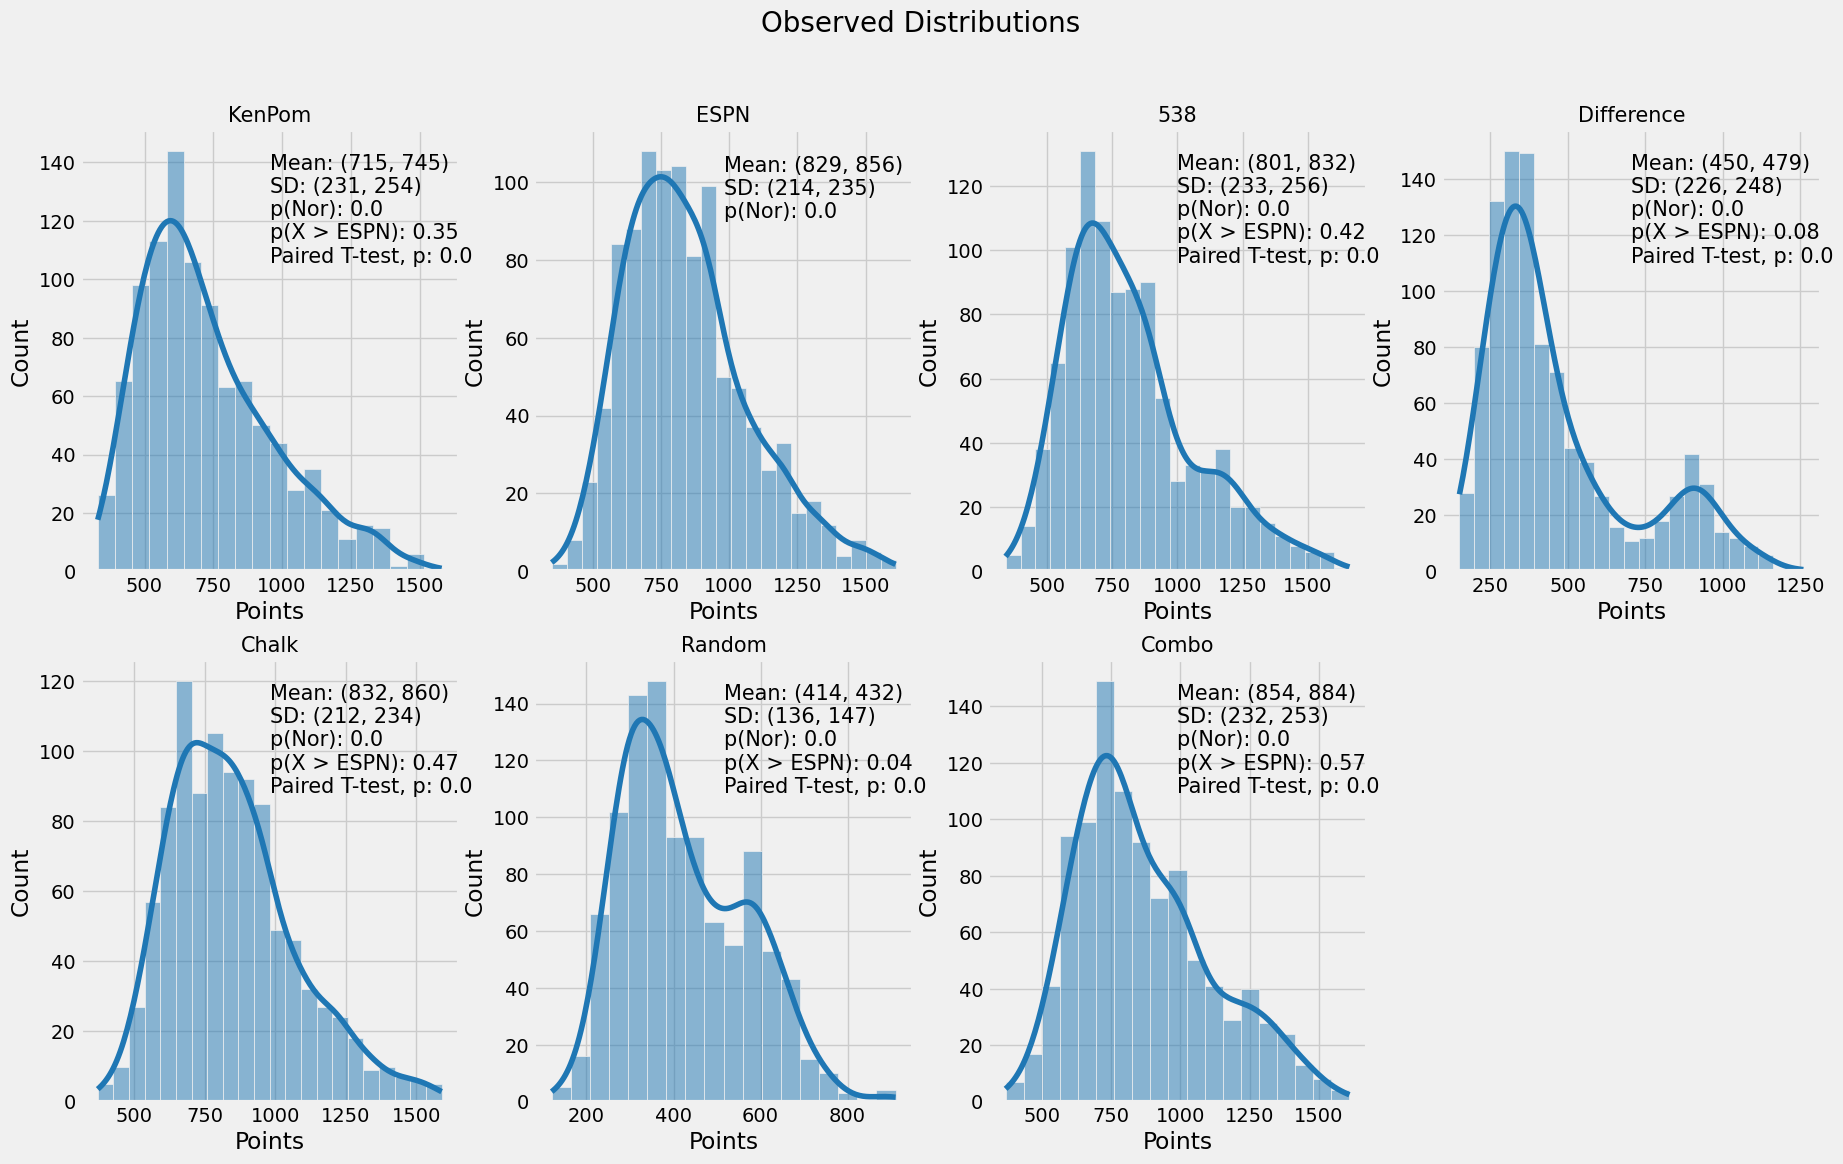

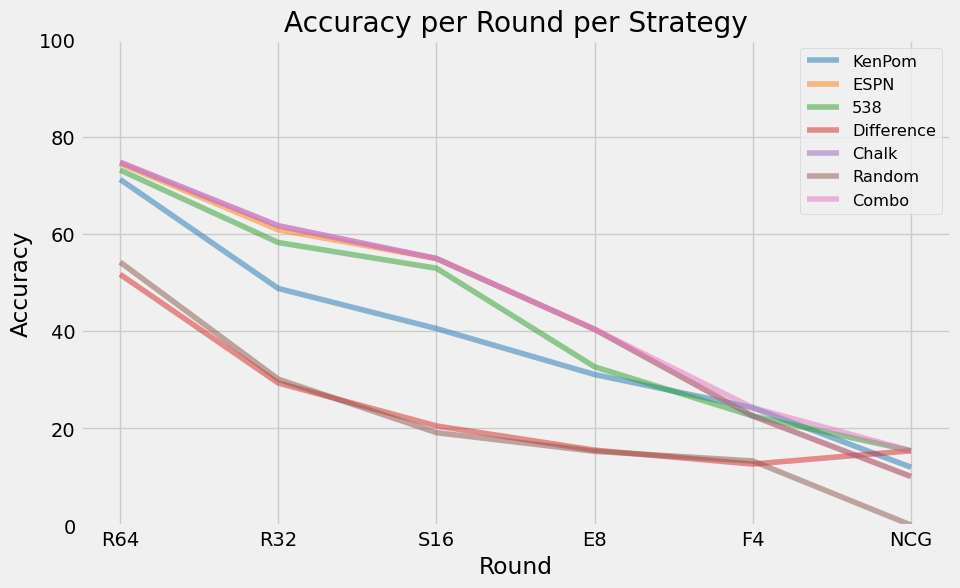

,R64,R32,S16,E8,F4,NCG
ESPN,74.50,60.86,54.95,40.38,22.55,10.1
Chalk,74.76,61.70,54.95,40.38,22.55,10.1
538,73.16,58.24,52.95,32.67,22.55,15.4
KenPom,71.23,48.79,40.54,31.08,24.25,12.0
Difference,51.70,29.33,20.50,15.52,12.65,15.4
Random,54.22,30.13,19.12,15.28,13.30,0.1
Combo,74.76,61.70,54.95,40.38,24.25,15.4


Real Points,  ESPN: 450
Real Points,  Chalk: 470
Real Points,  538: 520
Real Points,  KenPom: 440
Real Points,  Difference: 460
Real Points,  Random: 310
Real Points,  Combo: 470
{'West': {'F4': ['Alabama'], 'E8': ['Alabama'], 'S16': ['Alabama', 'Arizona'], 'R32': ['Alabama', 'Arizona', 'Virginia', 'Baylor'], 'R64': ['Alabama', 'Arizona', 'Virginia', 'Baylor', 'Maryland', 'San Diego State', 'Creighton', 'Missouri']}, 'East': {'F4': ['Purdue'], 'E8': ['Purdue'], 'S16': ['Purdue', 'Marquette'], 'R32': ['Purdue', 'Marquette', 'Tennessee', 'Kansas State'], 'R64': ['Purdue', 'Marquette', 'Tennessee', 'Kansas State', 'Memphis', 'Duke', 'Kentucky', 'Michigan State']}, 'South': {'F4': ['Houston'], 'E8': ['Houston'], 'S16': ['Houston', 'Texas'], 'R32': ['Houston', 'Texas', 'Indiana', 'Xavier'], 'R64': ['Houston', 'Texas', 'Indiana', 'Xavier', 'Iowa', 'Miami', 'Iowa State', 'Texas A&M']}, 'Midwest': {'F4': ['Kansas'], 'E8': ['Kansas'], 'S16': ['Kansas', 'UCLA'], 'R32': ['Kansas', 'UCLA', 'UConn'

In [131]:
# 2023
## real picks
real_picks_2023 = {'West':{'R64':['Alabama','Maryland','San Diego State','Furman',
                                'Creighton','Baylor','Missouri','Princeton'],
                     'R32':['Alabama','San Diego State','Creighton','Princeton'],
                     'S16':['San Diego State','Creighton'],
                     'E8':['San Diego State'],
                     'F4':['San Diego State']},
              'East':{'R64':['Farleigh Dickinson','Florida Atlantic','Duke','Tennessee',
                                'Kentucky','Kansas State','Michigan State','Marquette'],
                     'R32':['Florida Atlantic','Tennessee','Kansas State','Michigan State'],
                     'S16':['Florida Atlantic','Kansas State'],
                     'E8':['Florida Atlantic'],
                     'F4':['Florida Atlantic']},
              'South':{'R64':['Houston','Auburn','Miami','Indiana',
                                 'Pittsburgh','Xavier','Penn State','Texas'],
                     'R32':['Houston','Miami','Xavier','Texas'],
                     'S16':['Miami','Texas'],
                     'E8':['Miami'],
                     'F4':['Miami']},
              'Midwest':{'R64':['Kansas','Arkansas',"St. Mary's",'UConn',
                                   'TCU','Gonzaga','Northwestern','UCLA'],
                     'R32':['Arkansas','UConn','Gonzaga','UCLA'],
                     'S16':['UConn','Gonzaga'],
                     'E8':['UConn'],
                     'F4':['UConn']},
             'NCG':['San Diego State','UConn'],
             'Winner':'UConn'}
## play in teams to remove
playin_teams_2023 = ['Mississippi State', 'Nevada', 'Southeast Missouri State','Texas Southern']

## simulate picks
create_sim_year(espn_file='data/espn_2023.csv',
                               fivethirtyeight_file='data/538_2023.csv',
                               fivethirtyeight_date='2023-03-15',
                               fivethirtyeight_remove=playin_teams_2023,
                               kenpom_rat=kenpom_rat,
                               year=2023,
                               nsim=1000,
               real_picks = real_picks_2023)


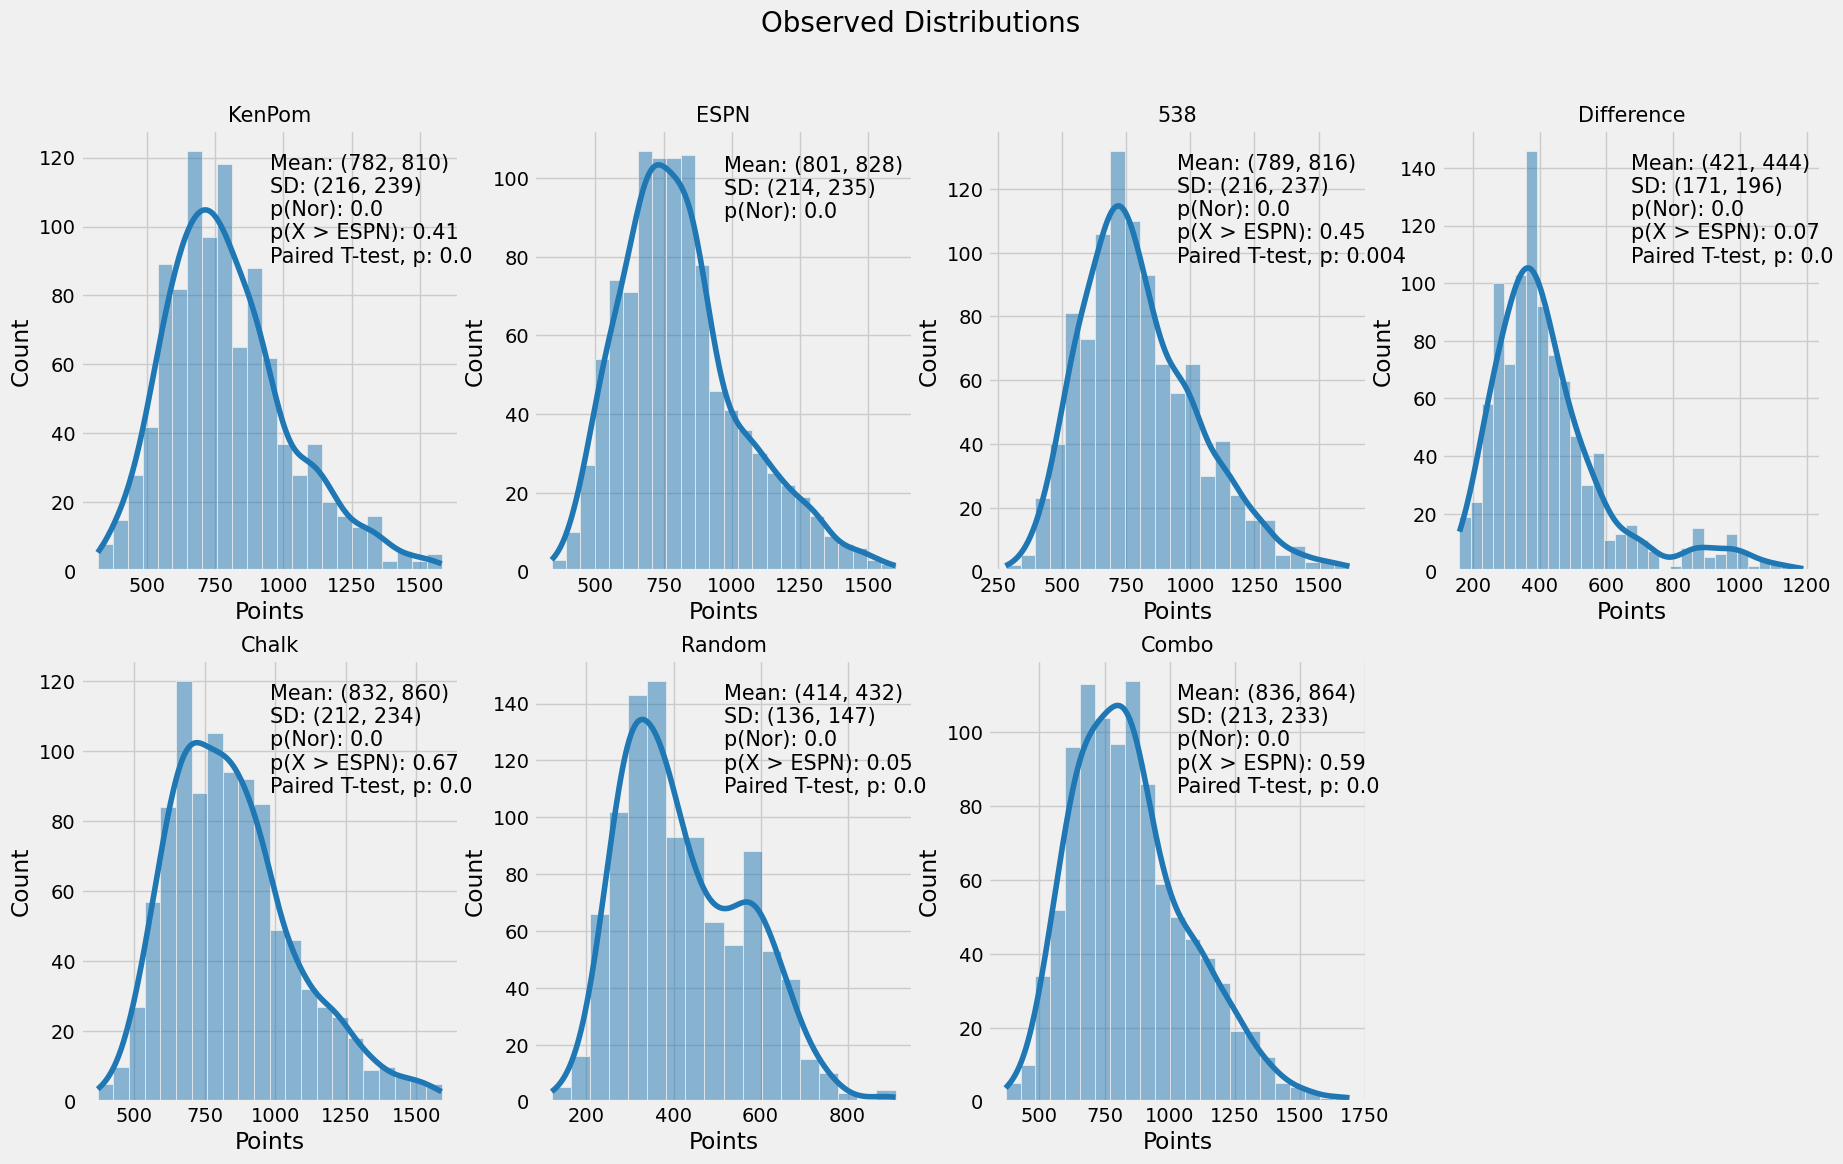

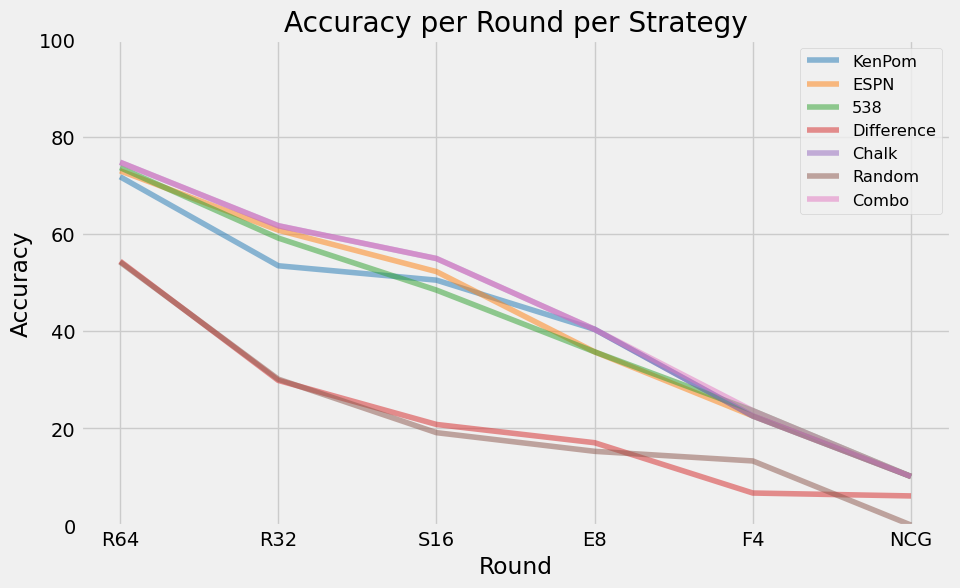

,R64,R32,S16,E8,F4,NCG
ESPN,73.00,60.78,52.26,35.75,22.55,10.1
Chalk,74.76,61.70,54.95,40.38,22.55,10.1
538,73.66,59.16,48.45,35.75,23.65,10.1
KenPom,71.78,53.46,50.50,40.38,22.55,10.1
Difference,54.40,29.87,20.81,17.05,6.70,6.1
Random,54.22,30.13,19.12,15.28,13.30,0.1
Combo,74.76,61.70,54.95,40.38,23.65,10.1


Real Points,  ESPN: 590
Real Points,  Chalk: 620
Real Points,  538: 790
Real Points,  KenPom: 650
Real Points,  Difference: 280
Real Points,  Random: 590
Real Points,  Combo: 780
{'West': {'F4': ['Gonzaga'], 'E8': ['Gonzaga'], 'S16': ['Gonzaga', 'Duke'], 'R32': ['Gonzaga', 'Duke', 'Arkansas', 'Texas Tech'], 'R64': ['Gonzaga', 'Duke', 'Arkansas', 'Texas Tech', 'Boise State', 'UConn', 'Alabama', 'Michigan State']}, 'East': {'F4': ['Baylor'], 'E8': ['Baylor'], 'S16': ['Baylor', 'Kentucky'], 'R32': ['Baylor', 'Kentucky', 'UCLA', 'Purdue'], 'R64': ['Baylor', 'Kentucky', 'UCLA', 'Purdue', 'North Carolina', "St. Mary's", 'Texas', 'Murray State']}, 'South': {'F4': ['Arizona'], 'E8': ['Arizona'], 'S16': ['Arizona', 'Villanova'], 'R32': ['Arizona', 'Villanova', 'Illinois', 'Tennessee'], 'R64': ['Arizona', 'Villanova', 'Illinois', 'Tennessee', 'Seton Hall', 'Houston', 'Colorado State', 'Ohio State']}, 'Midwest': {'F4': ['Kansas'], 'E8': ['Kansas'], 'S16': ['Kansas', 'Auburn'], 'R32': ['Kansas', '

In [132]:
# 2022

## real picks
real_picks_2022 = {'West':{'R64':['Gonzaga','Memphis','New Mexico State','Arkansas',
                                'Notre Dame','Texas Tech','Michigan State','Duke'],
                     'R32':['Gonzaga','Arkansas','Texas Tech','Duke'],
                     'S16':['Arkansas','Duke'],
                     'E8':['Duke'],
                     'F4':['Duke']},
              'East':{'R64':['Baylor','North Carolina',"St. Mary's",'UCLA',
                                'Texas','Purdue','Murray State',"St. Peter's"],
                     'R32':['North Carolina','UCLA','Purdue',"St. Peter's"],
                     'S16':['North Carolina',"St. Peter's"],
                     'E8':['North Carolina'],
                     'F4':['North Carolina']},
              'South':{'R64':['Arizona','TCU','Houston','Illinois',
                                 'Michigan','Tennessee','Ohio State','Villanova'],
                     'R32':['Arizona','Houston','Michigan','Villanova'],
                     'S16':['Houston','Villanova'],
                     'E8':['Villanova'],
                     'F4':['Villanova']},
              'Midwest':{'R64':['Kansas','Creighton','Richmond','Providence',
                                   'Iowa State','Wisconsin','Miami','Auburn'],
                     'R32':['Kansas','Providence','Iowa State','Miami'],
                     'S16':['Kansas','Miami'],
                     'E8':['Kansas'],
                     'F4':['Kansas']},
             'NCG':['North Carolina','Kansas'],
             'Winner':'Kansas'}
## play in teams to remove
playin_teams_2022 = ['Bryant', 'Wyoming', 'Rutgers','Texas A&M-Corpus Christi']

create_sim_year(espn_file='data/espn_2022.csv',
                fivethirtyeight_file='data/538_2022.csv',
                fivethirtyeight_date='2022-03-16',
                fivethirtyeight_remove=playin_teams_2022,
                kenpom_rat=kenpom_rat,
                year=2022,
                nsim=1000,
                real_picks=real_picks_2022)


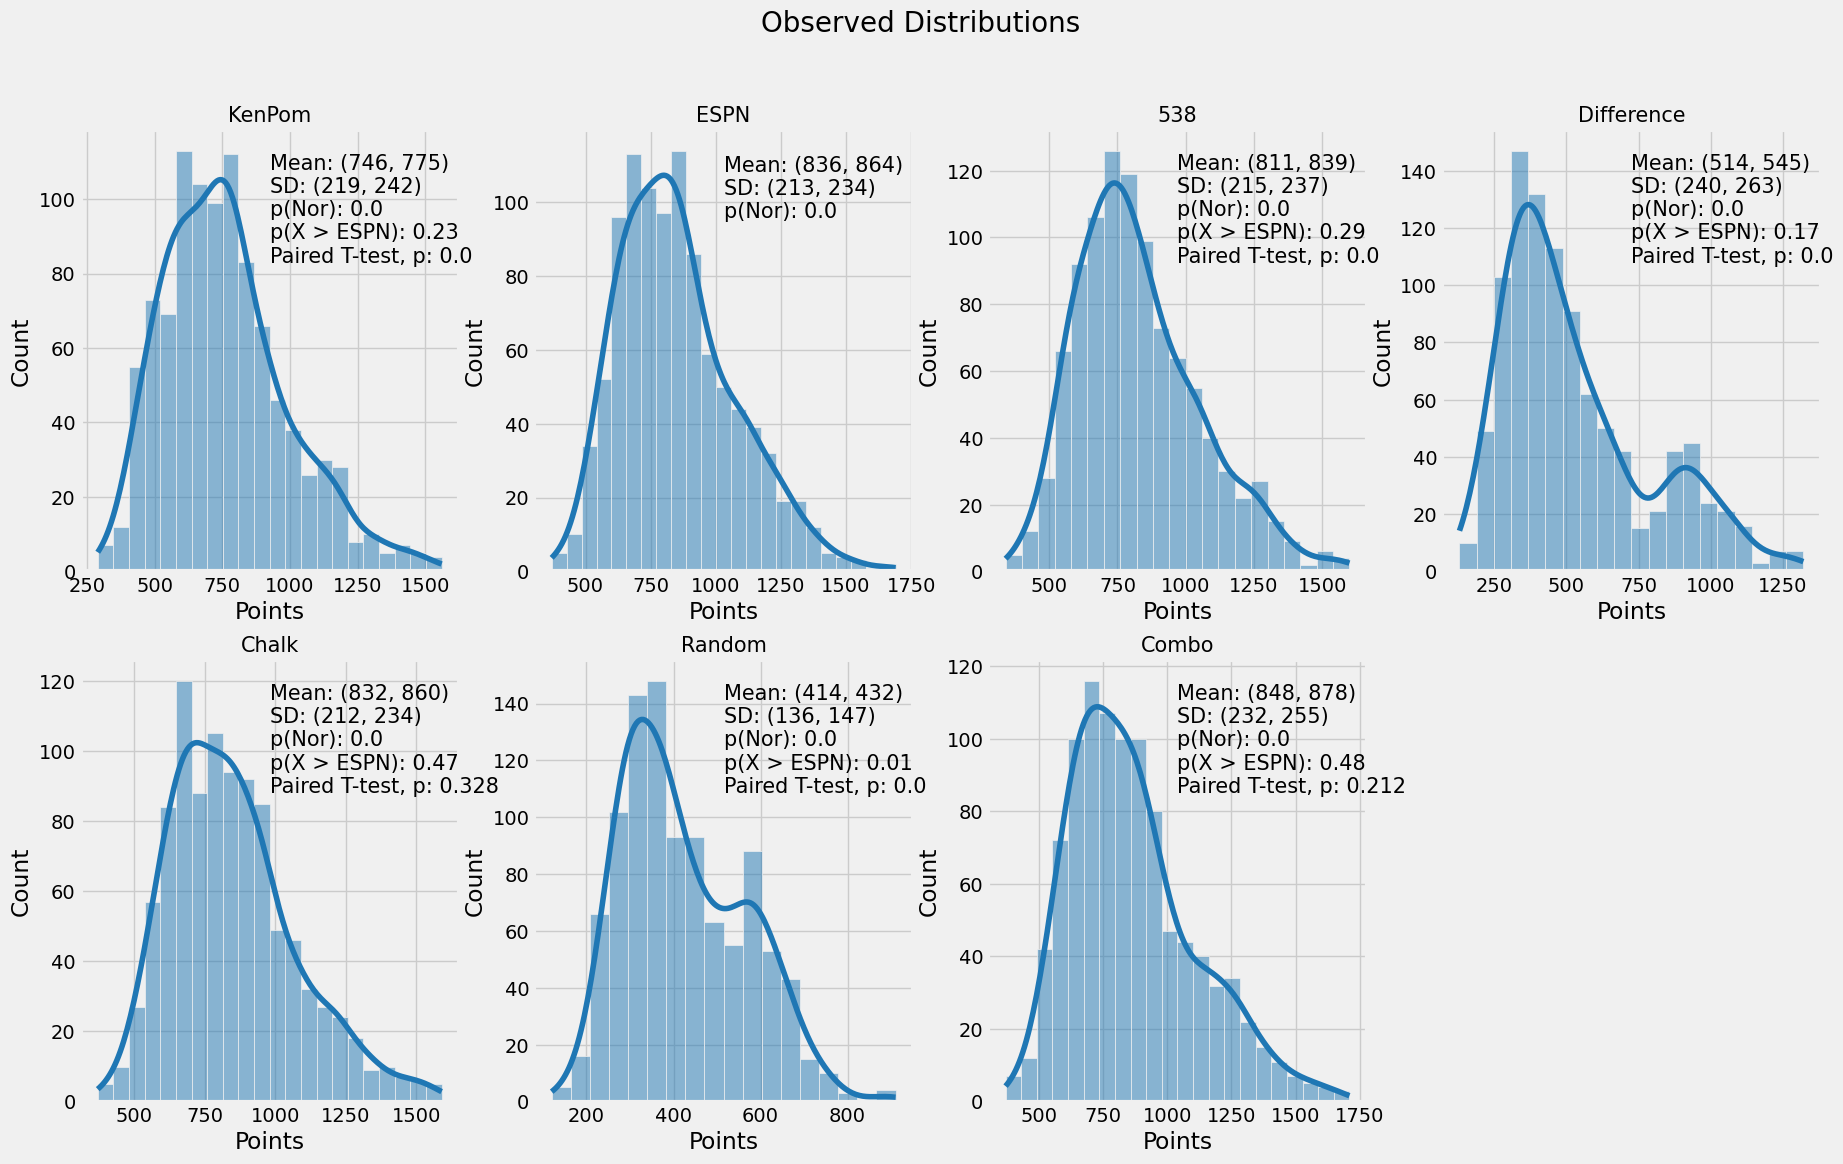

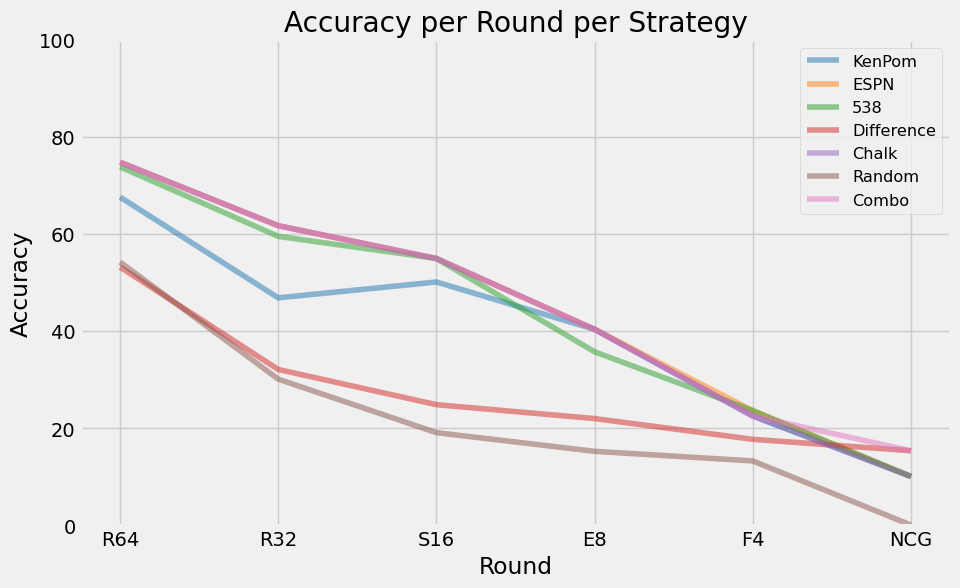

,R64,R32,S16,E8,F4,NCG
ESPN,74.76,61.70,54.95,40.38,23.65,10.1
Chalk,74.76,61.70,54.95,40.38,22.55,10.1
538,73.81,59.51,54.95,35.75,23.65,10.1
KenPom,67.58,46.86,50.12,40.38,22.55,10.1
Difference,53.19,32.12,24.88,22.02,17.75,15.4
Random,54.22,30.13,19.12,15.28,13.30,0.1
Combo,74.76,61.70,54.95,40.38,22.55,15.4


Real Points,  ESPN: 790
Real Points,  Chalk: 950
Real Points,  538: 820
Real Points,  KenPom: 1030
Real Points,  Difference: 980
Real Points,  Random: 150
Real Points,  Combo: 1270
{'West': {'F4': ['Gonzaga'], 'E8': ['Gonzaga'], 'S16': ['Gonzaga', 'Iowa'], 'R32': ['Gonzaga', 'Iowa', 'Virginia', 'Kansas'], 'R64': ['Gonzaga', 'Iowa', 'Virginia', 'Kansas', 'Oklahoma', 'Creighton', 'USC', 'Oregon']}, 'East': {'F4': ['Michigan'], 'E8': ['Michigan'], 'S16': ['Michigan', 'Alabama'], 'R32': ['Michigan', 'Alabama', 'Florida State', 'Texas'], 'R64': ['Michigan', 'Alabama', 'Florida State', 'Texas', 'LSU', 'Colorado', 'BYU', 'UConn']}, 'South': {'F4': ['Baylor'], 'E8': ['Baylor'], 'S16': ['Baylor', 'Ohio State'], 'R32': ['Baylor', 'Ohio State', 'Purdue', 'Arkansas'], 'R64': ['Baylor', 'Ohio State', 'Purdue', 'Arkansas', 'North Carolina', 'Villanova', 'Texas Tech', 'Florida']}, 'Midwest': {'F4': ['Illinois'], 'E8': ['Illinois'], 'S16': ['Illinois', 'Houston'], 'R32': ['Illinois', 'Houston', 'Oklah

In [133]:
# 2021

## real picks
real_picks_2021 = {'West':{'R64':['Gonzaga','Oklahoma','Creighton','Ohio',
                                'USC','Kansas','Oregon','Iowa'],
                     'R32':['Gonzaga','Creighton','USC','Oregon'],
                     'S16':['Arkansas','Duke'],
                     'E8':['Gonzaga'],
                     'F4':['Gonzaga']},
              'East':{'R64':['Michigan','KSU',"Colorado",'Florida State',
                                'UCLA','Abilene Christian','Maryland',"Alabama"],
                     'R32':['Michigan','Florida State','UCLA',"Alabama"],
                     'S16':['Michigan',"UCLA"],
                     'E8':['UCLA'],
                     'F4':['UCLA']},
              'South':{'R64':['Baylor','Wisconsin','Villanova','North Texas',
                                 'Texas Tech','Arkansas','Florida','Oral Roberts'],
                     'R32':['Baylor','Villanova','Arkansas','Oral Roberts'],
                     'S16':['Baylor','Arkansas'],
                     'E8':['Baylor'],
                     'F4':['Baylor']},
              'Midwest':{'R64':['Illinois','Loyola Chicago','Oregon State','Oklahoma State',
                                   'Syracuse','West Virginia','Rutgers','Houston'],
                     'R32':['Loyola Chicago','Oregon State','Syracuse','Houston'],
                     'S16':['Oregon State','Houston'],
                     'E8':['Houston'],
                     'F4':['Houston']},
             'NCG':['Gonzaga','Baylor'],
             'Winner':'Baylor'}
## play in teams to remove
playin_teams_2021 = ['Appalachian State', 'Wichita State', "Mount St. Mary's",'Michigan State']

## simulate picks
create_sim_year(espn_file='data/espn_2021.csv',
                fivethirtyeight_file='data/538_2021.csv',
                fivethirtyeight_date='2021-03-18',
                fivethirtyeight_remove=playin_teams_2021,
                kenpom_rat=kenpom_rat,
                year=2021,
                nsim=1000,
                real_picks=real_picks_2021)


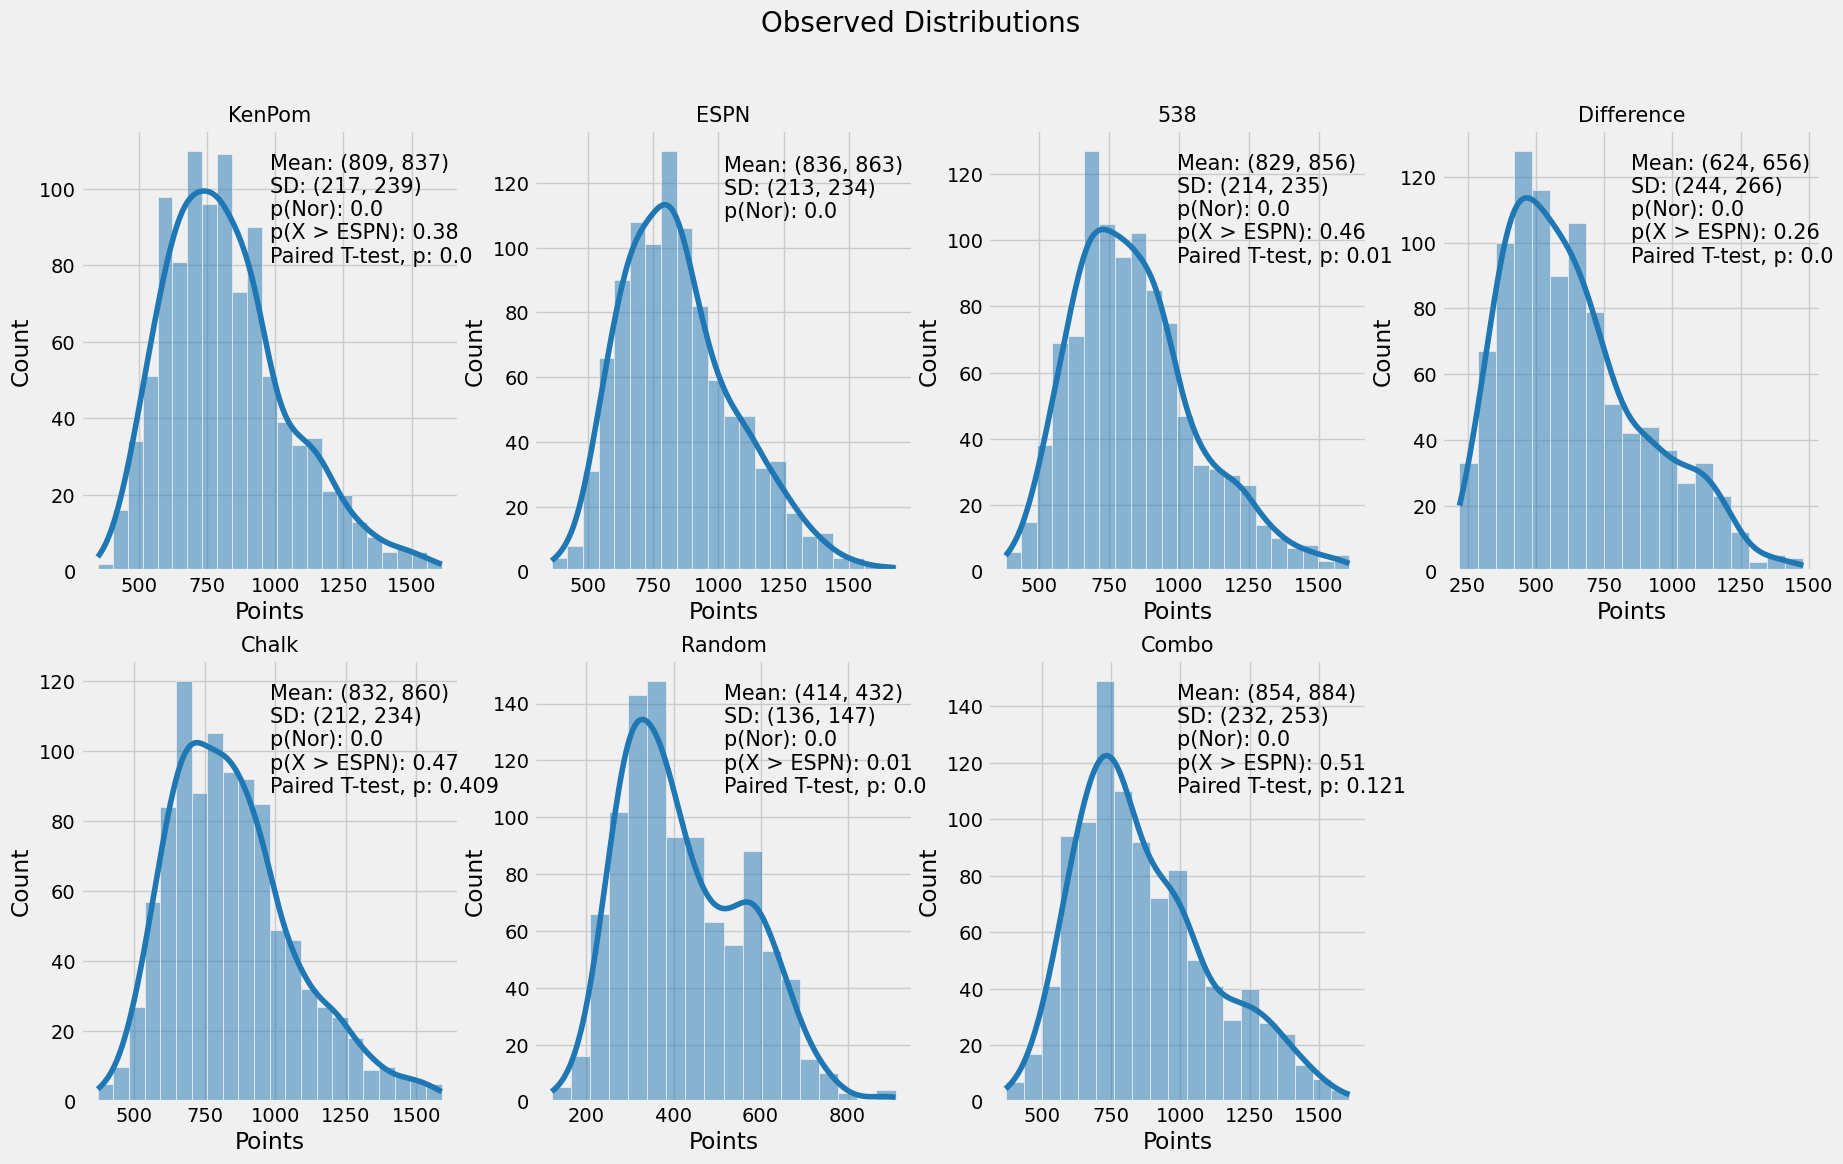

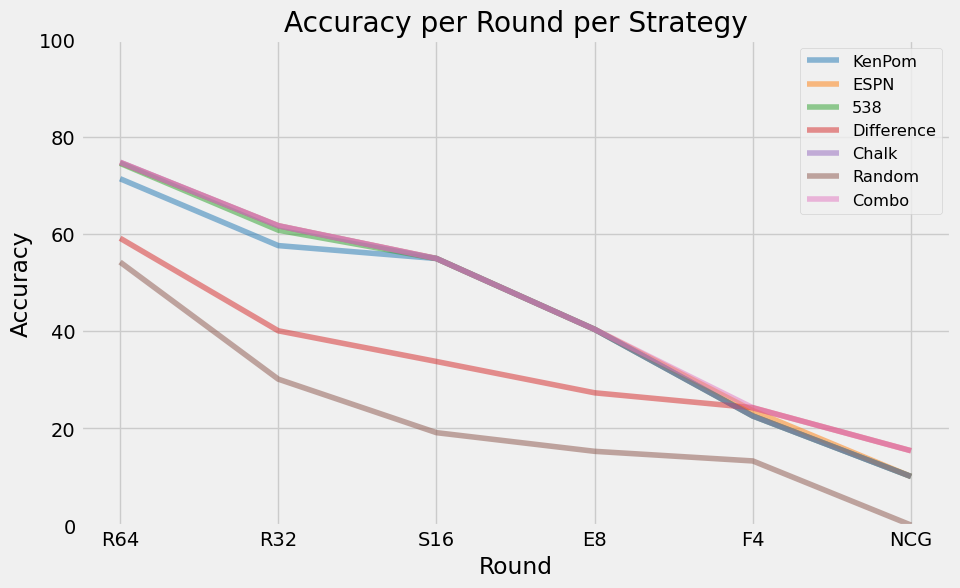

,R64,R32,S16,E8,F4,NCG
ESPN,74.71,61.70,54.95,40.38,23.65,10.1
Chalk,74.76,61.70,54.95,40.38,22.55,10.1
538,74.54,60.78,54.95,40.38,22.55,10.1
KenPom,71.37,57.61,54.95,40.38,22.55,10.1
Difference,59.13,40.08,33.76,27.32,24.25,15.4
Random,54.22,30.13,19.12,15.28,13.30,0.1
Combo,74.76,61.70,54.95,40.38,24.25,15.4


Real Points,  ESPN: 770
Real Points,  Chalk: 920
Real Points,  538: 950
Real Points,  KenPom: 1020
Real Points,  Difference: 1290
Real Points,  Random: 370
Real Points,  Combo: 1240
{'West': {'F4': ['Duke'], 'E8': ['Duke'], 'S16': ['Duke', 'Michigan State'], 'R32': ['Duke', 'Michigan State', 'Virginia Tech', 'LSU'], 'R64': ['Duke', 'Michigan State', 'Virginia Tech', 'LSU', 'VCU', 'Mississippi State', 'Maryland', 'Louisville']}, 'East': {'F4': ['Gonzaga'], 'E8': ['Gonzaga'], 'S16': ['Gonzaga', 'Michigan'], 'R32': ['Gonzaga', 'Michigan', 'Florida State', 'Texas Tech'], 'R64': ['Gonzaga', 'Michigan', 'Florida State', 'Texas Tech', 'Syracuse', 'Marquette', 'Buffalo', 'Nevada']}, 'South': {'F4': ['Virginia'], 'E8': ['Virginia'], 'S16': ['Virginia', 'Tennessee'], 'R32': ['Virginia', 'Tennessee', 'Kansas State', 'Purdue'], 'R64': ['Virginia', 'Tennessee', 'Kansas State', 'Purdue', 'Mississippi', 'Wisconsin', 'Villanova', 'Cincinnati']}, 'Midwest': {'F4': ['North Carolina'], 'E8': ['North Caro

In [134]:
# 2019

## real picks
real_picks_2019 = {'West':{'R64':['Duke','UCF','Liberty','Virginia Tech',
                                  'Maryland','LSU','Minnesota','Michigan State'],
                     'R32':['Duke','Virginia Tech','LSU','Michigan State'],
                     'S16':['Duke','Michigan State'],
                     'E8':['Michigan State'],
                     'F4':['Michigan State']},
              'East':{'R64':['Gonzaga','Baylor',"Murray State",'Florida State',
                                'Buffalo','Texas Tech','Florida',"Michigan"],
                     'R32':['Gonzaga','Florida State','Texas Tech',"Michigan"],
                     'S16':['Gonzaga',"Texas Tech"],
                     'E8':['Texas Tech'],
                     'F4':['Texas Tech']},
              'South':{'R64':['Virginia','Oklahoma','Oregon','UC Irvine',
                                 'Villanova','Purdue','Iowa','Tennessee'],
                     'R32':['Virginia','Oregon','Purdue','Tennessee'],
                     'S16':['Virginia','Purdue'],
                     'E8':['Virginia'],
                     'F4':['Virginia']},
              'Midwest':{'R64':['North Carolina','Washington','Auburn','Kansas',
                                   'Ohio State','Houston','Wofford','Kentucky'],
                     'R32':['North Carolina','Auburn','Houston','Kentucky'],
                     'S16':['Auburn','Kentucky'],
                     'E8':['Auburn'],
                     'F4':['Auburn']},
             'NCG':['Texas Tech','Virginia'],
             'Winner':'Virginia'}
## playin teams to remove
playin_teams_2019 = ['North Carolina Central', 'Temple', "St. John's (NY)",'Prairie View']

## simulate picks
create_sim_year(espn_file='data/espn_2019.csv',
                fivethirtyeight_file='data/538_2019.csv',
                fivethirtyeight_date='2019-03-20',
                fivethirtyeight_remove=playin_teams_2019,
                kenpom_rat=kenpom_rat,
                year=2019,
                nsim=1000,
                real_picks=real_picks_2019)


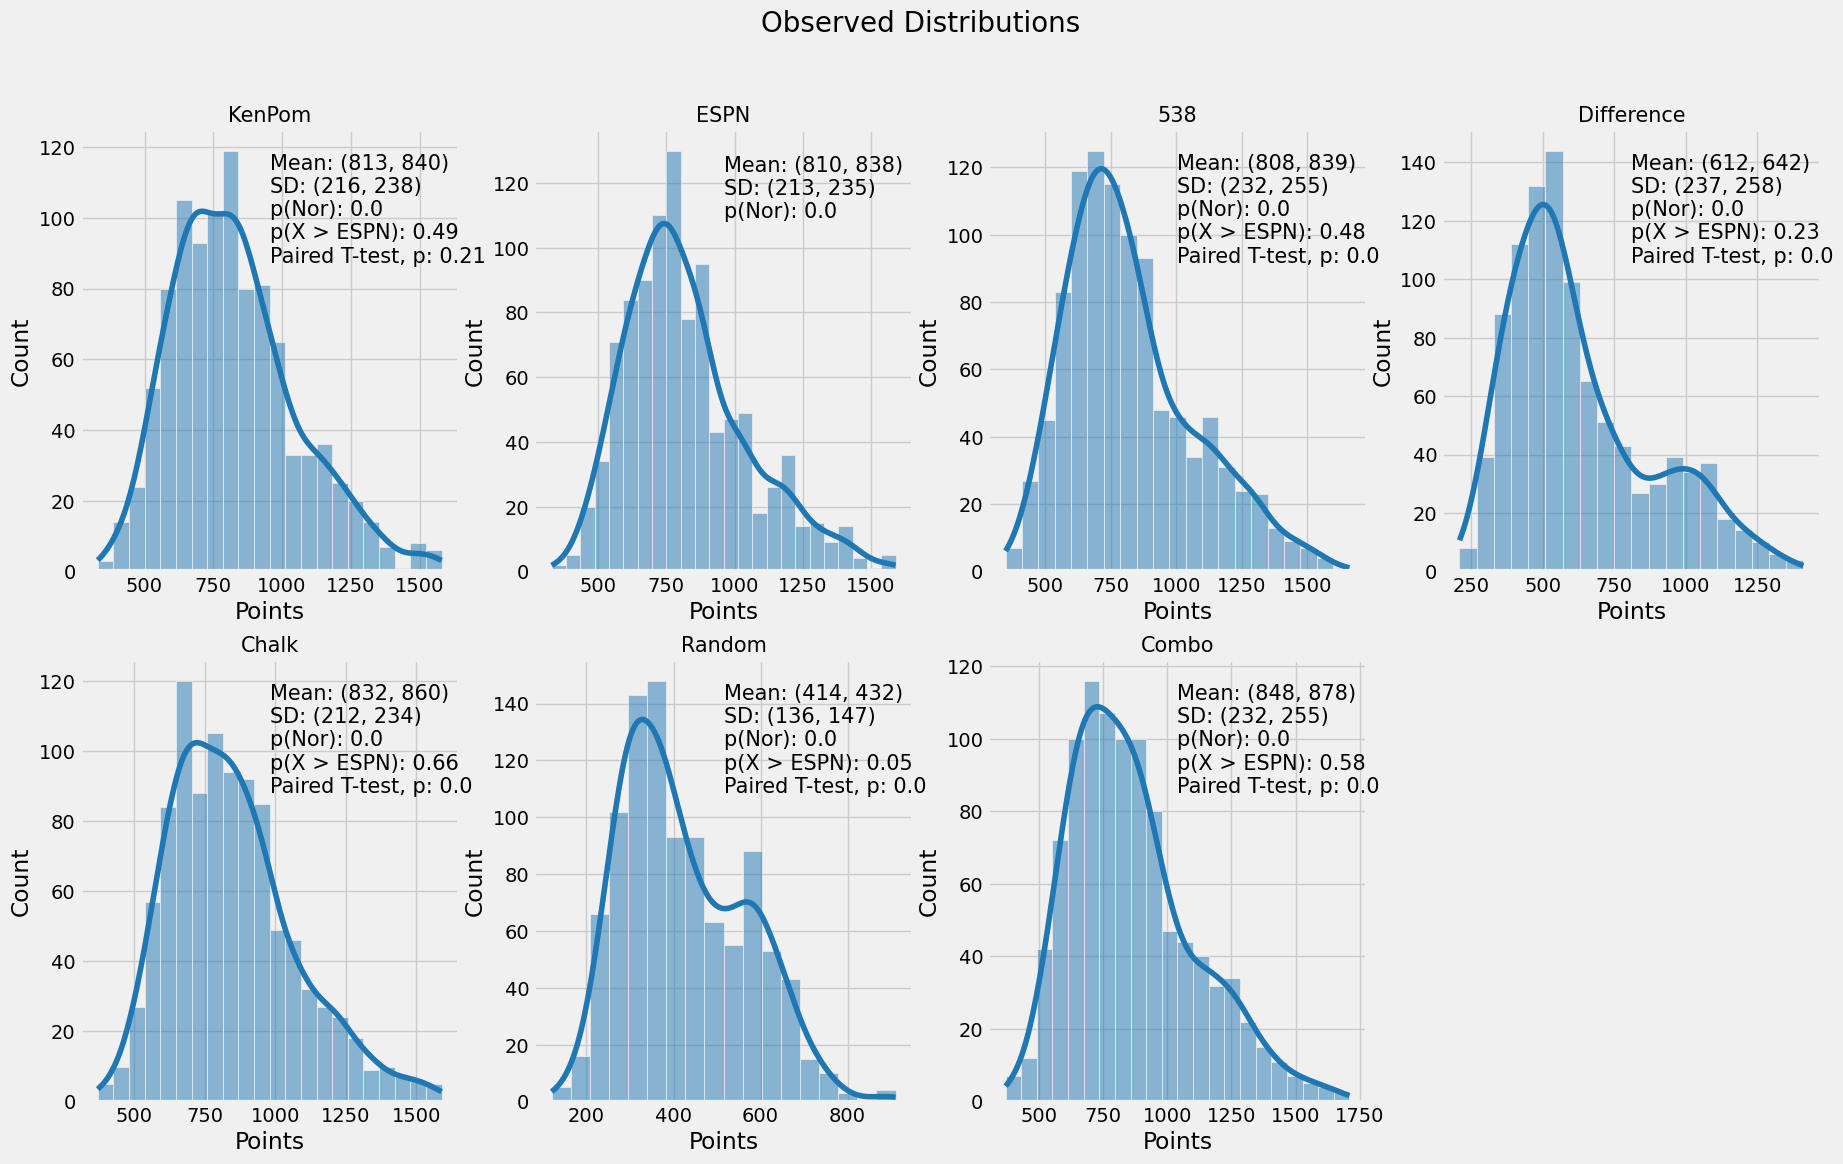

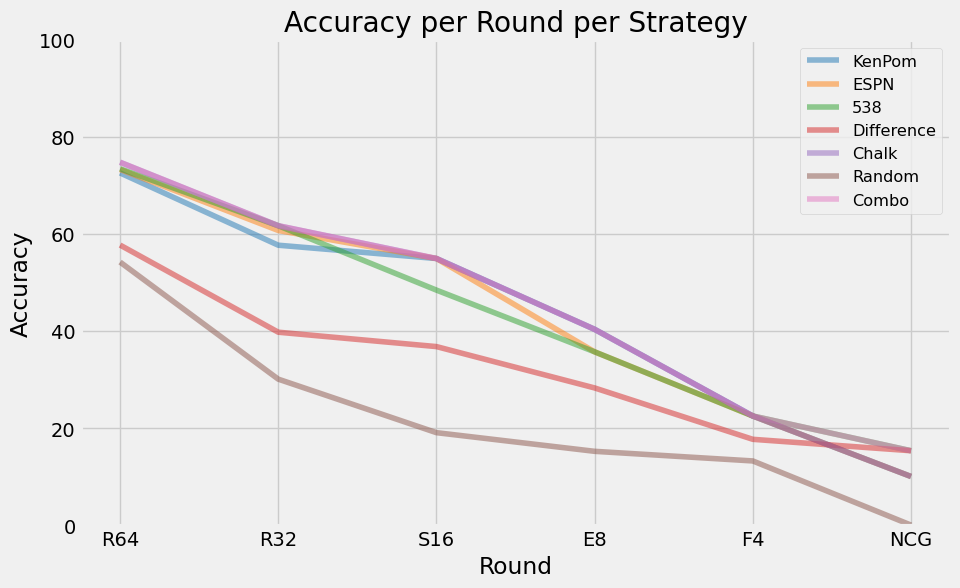

,R64,R32,S16,E8,F4,NCG
ESPN,73.28,60.72,54.95,35.75,22.55,10.1
Chalk,74.76,61.70,54.95,40.38,22.55,10.1
538,73.42,61.70,48.45,35.75,22.55,15.4
KenPom,72.56,57.69,54.95,40.38,22.55,10.1
Difference,57.72,39.79,36.83,28.32,17.75,15.4
Random,54.22,30.13,19.12,15.28,13.30,0.1
Combo,74.76,61.70,54.95,40.38,22.55,15.4


Real Points,  ESPN: 830
Real Points,  Chalk: 810
Real Points,  538: 1140
Real Points,  KenPom: 850
Real Points,  Difference: 1050
Real Points,  Random: 660
Real Points,  Combo: 1130
{'West': {'F4': ['Virginia'], 'E8': ['Virginia'], 'S16': ['Virginia', 'Cincinnati'], 'R32': ['Virginia', 'Cincinnati', 'Arizona', 'Tennessee'], 'R64': ['Virginia', 'Cincinnati', 'Arizona', 'Tennessee', 'Creighton', 'Kentucky', 'Miami', 'Nevada']}, 'East': {'F4': ['Xavier'], 'E8': ['Xavier'], 'S16': ['Xavier', 'North Carolina'], 'R32': ['Xavier', 'North Carolina', 'Gonzaga', 'Michigan'], 'R64': ['Xavier', 'North Carolina', 'Gonzaga', 'Michigan', 'Missouri', 'Ohio State', 'Houston', 'Texas A&M']}, 'South': {'F4': ['Villanova'], 'E8': ['Villanova'], 'S16': ['Villanova', 'Purdue'], 'R32': ['Villanova', 'Purdue', 'Wichita State', 'Texas Tech'], 'R64': ['Villanova', 'Purdue', 'Wichita State', 'Texas Tech', 'Virginia Tech', 'West Virginia', 'Florida', 'Arkansas']}, 'Midwest': {'F4': ['Kansas'], 'E8': ['Kansas'], '

In [135]:
# 2018

## real picks
real_picks_2018 = {'West':{'R64':['UMBC','Kansas State','Kentucky','Buffalo',
                                  'Loyola Chicago','Tennessee','Nevada','Cincinnati'],
                     'R32':['Kansas State','Kentucky','Loyola Chicago','Nevada'],
                     'S16':['Kansas State','Loyola Chicago'],
                     'E8':['Loyola Chicago'],
                     'F4':['Loyola Chicago']},
              'East':{'R64':['Xavier','Florida State',"Ohio State",'Gonzaga',
                                'Houston','Michigan','Texas A&M',"North Carolina"],
                     'R32':['Florida State','Gonzaga','Michigan',"Texas A&M"],
                     'S16':['Florida State',"Michigan"],
                     'E8':['Michigan'],
                     'F4':['Michigan']},
              'South':{'R64':['Villanova','Alabama','West Virginia','Marshall',
                                 'Florida','Texas Tech','Butler','Purdue'],
                     'R32':['Villanova','West Virginia','Texas Tech','Purdue'],
                     'S16':['Villanova','Texas Tech'],
                     'E8':['Villanova'],
                     'F4':['Villanova']},
              'Midwest':{'R64':['Kansas','Seton Hall','Clemson','Auburn',
                                   'Syracuse','Michigan State','Rhode Island','Duke'],
                     'R32':['Kansas','Clemson','Syracuse','Duke'],
                     'S16':['Kansas','Duke'],
                     'E8':['Kansas'],
                     'F4':['Kansas']},
             'NCG':['Michigan','Villanova'],
             'Winner':'Villanova'}
## play in teams to remove
playin_teams_2018 = ['North Carolina Central', 'Arizona State', "Long Island University",'UCLA']

## simulate picks
create_sim_year(espn_file='data/espn_2018.csv',
                fivethirtyeight_file='data/538_2018.csv',
                fivethirtyeight_date='2018-03-14',
                fivethirtyeight_remove=playin_teams_2018,
                kenpom_rat=kenpom_rat,
                year=2018,
                nsim=1000,
                real_picks=real_picks_2018)
